In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install torch_geometric

In [4]:
%%writefile MI_electrode_positions.txt

FC5 -0.882718 0.338844 0.325568
FC3 -0.676377 0.359636 0.642788
FC1 -0.374710 0.374710 0.848048
FCz 0.000000 0.390731 0.920505
FC2 0.374710 0.374710 0.848048
FC4 0.676377 0.359636 0.642788
FC6 0.882718 0.338844 0.325568
C5 -0.933580 0.000000 0.358368
C3 -0.719340 0.000000 0.694658
C1 -0.390731 0.000000 0.920505
Cz 0.000000 0.000000 1.000000
C2 0.390731 0.000000 0.920505
C4 0.719340 0.000000 0.694658
C6 0.933580 0.000000 0.358368
CP5 -0.882718 -0.338844 0.325568
CP3 -0.676377 -0.359636 0.642788
CP1 -0.374710 -0.374710 0.848048
CPz 0.000000 -0.390731 0.920505
CP2 0.374710 -0.374710 0.848048
CP4 0.676377 -0.359636 0.642788
CP6 0.882718 -0.338844 0.325568
Fp1 -0.308829 0.950477 -0.034899
Fpz 0.000000 0.999391 -0.034899
Fp2 0.308829 0.950477 -0.034899
AF7 -0.615286 0.787531 -0.034899
AF3 -0.375595 0.884846 0.275637
AFz 0.000000 0.933580 0.358368
AF4 0.375595 0.884846 0.275637
AF8 0.615286 0.787531 -0.034899
F7 -0.808524 0.587427 -0.034899
F5 -0.728993 0.633704 0.258819
F3 -0.545007 0.673028 0.500000
F1 -0.286965 0.710264 0.642788
Fz 0.000000 0.719340 0.694658
F2 0.286965 0.710264 0.642788
F4 0.545007 0.673028 0.500000
F6 0.728993 0.633704 0.258819
F8 0.808524 0.587427 -0.034899
FT7 -0.950477 0.308829 -0.034899
FT8 0.950477 0.308829 -0.034899
T7 -0.999391 0.000000 -0.034899
T8 0.999391 0.000000 -0.034899
T9 -0.906308 0.000000 -0.422618
T10 0.906308 0.000000 -0.422618
TP7 -0.950477 -0.308829 -0.034899
TP8 0.950477 -0.308829 -0.034899
P7 -0.808524 -0.587427 -0.034899
P5 -0.728993 -0.633704 0.258819
P3 -0.545007 -0.673028 0.500000
P1 -0.286965 -0.710264 0.642788
Pz 0.000000 -0.719340 0.694658
P2 0.286965 -0.710264 0.642788
P4 0.545007 -0.673028 0.500000
P6 0.728993 -0.633704 0.258819
P8 0.808524 -0.587427 -0.034899
PO7 -0.587427 -0.808524 -0.034899
PO3 -0.375595 -0.884846 0.275637
POz 0.000000 -0.933580 0.358368
PO4 0.375595 -0.884846 0.275637
PO8 0.587427 -0.808524 -0.034899
O1 -0.308829 -0.950477 -0.034899
Oz 0.000000 -0.999391 -0.034899
O2 0.308829 -0.950477 -0.034899
Iz 0.000000 -0.906308 -0.422618

Writing MI_electrode_positions.txt


In [5]:
!pip install mne scipy


In [6]:
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/

--2024-10-09 15:22:13--  https://physionet.org/files/eegmmidb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'physionet.org/files/eegmmidb/1.0.0/index.html'

physionet.org/files     [ <=>                ]  12.75K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2024-10-09 15:22:13 (245 MB/s) - 'physionet.org/files/eegmmidb/1.0.0/index.html' saved [13059]

Loading robots.txt; please ignore errors.
--2024-10-09 15:22:13--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: 'physionet.org/robots.txt'

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2024-10-09 15:22:13 (18.4 MB/s) - 'physionet.org/robots.txt' saved [22/22]

--2024-10-09

In [ ]:
import mne
import scipy.io
import os

# Define the base input folder and output folder
input_base_folder = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/'  # Base folder containing S001 to S109
output_base_folder = '/kaggle/working/physionet.org/files/eegmmidb/matfiles/'  # Base folder to save .mat files

# Function to load EDF files from subfolders and save them as .mat
def convert_edf_to_mat(input_base_folder, output_base_folder):
    # Create the output base folder if it doesn't exist
    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    # Loop through all series subfolders (e.g., S001 to S109)
    for subfolder in os.listdir(input_base_folder):
        subfolder_path = os.path.join(input_base_folder, subfolder)
        
        # Only process folders starting with 'S' (e.g., S001, S002)
        if os.path.isdir(subfolder_path) and subfolder.startswith('S'):
            # Create a subfolder in the output folder to store corresponding .mat files
            output_subfolder = os.path.join(output_base_folder, subfolder)
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)
            
            # Loop through all .edf files in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".edf"):
                    edf_path = os.path.join(subfolder_path, filename)
                    
                    # Load the .edf file
                    raw_data = mne.io.read_raw_edf(edf_path, preload=True)
                    
                    # Get the EEG data and sampling rate
                    eeg_data = raw_data.get_data()
                    sampling_rate = raw_data.info['sfreq']
                    
                    # Save the data as a .mat file
                    mat_filename = os.path.join(output_subfolder, filename.replace(".edf", ".mat"))
                    scipy.io.savemat(mat_filename, {
                        'eeg_data': eeg_data,
                        'sampling_rate': sampling_rate
                    })
                    print(f"Saved {mat_filename}")

# Run the conversion for all series
convert_edf_to_mat(input_base_folder, output_base_folder)


# **FOR 1 EDF FILE**

In [7]:
import mne
import scipy.io
import os

# Define the input and output folder paths
input_folder = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/'  # Update to the folder where your .edf files are
output_folder = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/'  # Path to save .mat files

# Function to load EDF files and save them as .mat
def convert_edf_to_mat(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the .edf files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".edf"):
            edf_path = os.path.join(input_folder, filename)
            
            # Load the .edf file
            raw_data = mne.io.read_raw_edf(edf_path, preload=True)
            
            # Get the EEG data and sampling rate
            eeg_data = raw_data.get_data()
            sampling_rate = raw_data.info['sfreq']
            
            # Save the data as a .mat file
            mat_filename = os.path.join(output_folder, filename.replace(".edf", ".mat"))
            scipy.io.savemat(mat_filename, {
                'eeg_data': eeg_data,
                'sampling_rate': sampling_rate
            })
            print(f"Saved {mat_filename}")

# Run the conversion
convert_edf_to_mat(input_folder, output_folder)


Extracting EDF parameters from /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/S002R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Saved /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R09.mat
Extracting EDF parameters from /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Saved /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R14.mat
Extracting EDF parameters from /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/S002R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Saved /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R11.mat
Extracting EDF parameters fr

# **model.config**

In [8]:
%%writefile model.config
[path]
# electrodes coordinates file path.
electro_position_file_path = '/kaggle/working/MI_electrode_positions.txt'
#data_path = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S004/matfiles/S004R03.mat'
data_path = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/'
# List all .mat files in the directory
mat_files = [f for f in os.listdir(data_path) if f.endswith('.mat')]

for mat_file in mat_files:
    data_file = os.path.join(data_path, mat_file)
    print(f"Loading file: {data_file}")
    # Load the .mat file
    all_data = h5py.File(data_file, 'r')
# save model state fil and config files.
save_path = '/kaggle/working/output/'
# save tensorboard log files.
log_dir = '/kaggle/working/log_dir/'

[preprocess]
# convert raw signal to spike train
raw_to_spike_thr = 0.2
# number of nodes to be connected for constructing graph
k = 3
# use distance to construct graph
construct_mode = 'dis'
# use 3d electrodes coordinates to compute the distance.
use_2d = 0
# use knn method to construct graph
knn_or_thr = 1
# load dataset, stimulate time step
time_window = 8

[train]
# the number of k-fold runs
kf_num = 5
batch_size = 128
learning_rate = 0.001
num_epochs = 100
seed = 2022
lr_scheduler_value = 40

[model]
model_name = 'GraLstmEnc'
# classes number
num_classes = 4
# neuronal threshold,  hyper-parameters of approximate function
thresh = 0.5
lens = 3.0
decay = 0.6
# encoding step, act_enc_fun parameters.
enc_thresh = 0.5
enc_lens = 3.0
# model paramters  ps: cfg_enc[-1] == cfg_gnn[0]
cfg_enc = 80,80
cfg_gnn = 80,64
cfg_gnn2 = 64,32
cfg_s = 64,64
cfg_fc = 128,256
# dropout coefficient
gamma = 0.2
# EGC parameters num_heads. num_bases.
num_heads = 8
num_bases = 4

Writing model.config


In [9]:
run model.config 

NameError: name 'path' is not defined

# **FOR ALL FILES**

In [12]:
%%writefile model.config

[path]
# electrodes coordinates file path.
electro_position_file_path = MI_electrode_positions.txt
data_path = /media/sherie/D2C0C8C2C0C8AE53/TokenG/processedData/processed_data.mat
# save model state fil and config files.
save_path = ./MI-final/output/
# save tensorboard log files.
log_dir = ./MI-final/log_dir/

[preprocess]
# convert raw signal to spike train
raw_to_spike_thr = 0.2
# number of nodes to be connected for constructing graph
k = 3
# use distance to construct graph
construct_mode = dis
# use 3d electrodes coordinates to compute the distance.
use_2d = 0
# use knn method to construct graph
knn_or_thr = 1
# load dataset, stimulate time step
time_window = 8

[train]
# the number of k-fold runs
kf_num = 5
batch_size = 128
learning_rate = 0.001
num_epochs = 100
seed = 2022
lr_scheduler_value = 40

[model]
model_name = GraLstmEnc
# classes number
num_classes = 4
# neuronal threshold,  hyper-parameters of approximate function
thresh = 0.5
lens = 3.0
decay = 0.6
# encoding step, act_enc_fun parameters.
enc_thresh = 0.5
enc_lens = 3.0
# model paramters  ps: cfg_enc[-1] == cfg_gnn[0]
cfg_enc = 80,80
cfg_gnn = 80,64
cfg_gnn2 = 64,32
cfg_s = 64,64
cfg_fc = 128,256
# dropout coefficient
gamma = 0.2
# EGC parameters num_heads. num_bases.
num_heads = 8
num_bases = 4

Overwriting model.config


# **load_graph_data_KF**

In [10]:
from structureGraph import BrainGraphMB
print(brainGraph)

ModuleNotFoundError: No module named 'structureGraph'

In [16]:
%%writefile load_graph_data_KF.py

import torch
from torch.utils.data import Dataset
import scipy.io as scio
#from structureGraph.py import BrainGraphMB
import h5py
import numpy as np
from structureGraph import BrainGraphMB
from torch_geometric.data import Data
                  ################# graph data can be mini-batch.######################

#  ==== method one =====

class OurDatasetKF(Dataset):
    def __init__(self, datas, labels, train_index, test_index, electro_file_path, construct_mode = 'dis', is_thr = 0, use_2d = 0, knn_or_thr = 1, k = 7, time_win=64, raw_to_spike_thr=0.5, train=True):
        self.all_datas, self.all_labels = datas, labels  # load big dataset (> matlab v7.3 version)

        # construct graph1 and graph2
        self.graph = BrainGraphMB(electro_file_path=electro_file_path,
                                construct_mode=construct_mode, use_2d=use_2d, knn_or_thr = knn_or_thr, k = k)  # use the same graph structure.

        self.time_win = time_win
        # use thr to convert raw to spike
        self.is_thr = is_thr
        if is_thr:
            self.raw_to_spike_thr = raw_to_spike_thr

        if train:
            self.data = self.all_datas[train_index]
            self.label = self.all_labels[train_index]
        else:
            self.data = self.all_datas[test_index]
            self.label = self.all_labels[test_index]

    def __getitem__(self, index):
        # data_noise = self.data[index] + add_gauss_noise_by_SNR(self.data[index], 25)
        # data_r = data_noise.reshape([64, int(640 / self.time_win), self.time_win], order='F')
        # print('raw_signal_ =', self.data[index][0, :].tolist())
        # print('noise_signal_ =', data_noise[0, :].tolist())
        # print('noise_ =', (data_noise[0, :] - self.data[index][0, :]).tolist())
        # exit()

        # 2. raw code.
        data_r = self.data[index].reshape([64, int(640 / self.time_win), self.time_win], order='F')
        data_raw = torch.from_numpy(data_r).float()  # 640 time points split to 160bins e

        data = data_raw  # not use thr to encode raw signal
        if self.is_thr:
            data = (data_raw > self.raw_to_spike_thr).float()   # simple using a thr value to encode raw signal to spike trians.
            # data = torch.rand_like(data_raw).le(data_raw).to(data_raw)  # using poisson encoder.
        label = torch.LongTensor(self.label[index])

        # get graph
        graph_data = self.graph(data)
        return graph_data, label

    def __len__(self):
        return len(self.label)

def add_gauss_noise(signal, mean = 0, sigma = 0.2):
    noise = np.random.normal(mean, sigma, signal.shape)
    noise_data = signal + noise
    noise_data = np.clip(noise_data, 0, 1)
    return noise_data

def add_gauss_noise_by_SNR(signal, snr):
    '''
    signal: raw signal
    snr: signal noise ratio.
    return : noise.
    '''
    np.random.seed(2022)
    noise = np.random.normal(0, 0.05, signal.shape)
    noise = noise - np.mean(noise)
    signal_power = (1/signal.shape[0])*np.sum(np.power(signal, 2))
    noise_variance = signal_power/np.power(10, (snr/10))
    noise = (np.sqrt(noise_variance / np.std(noise))) * noise
    return noise

Overwriting load_graph_data_KF.py


In [17]:
%%writefile load_graph_data_KF.py

import torch
from torch.utils.data import Dataset
import scipy.io as scio
#from structureGraph.py import BrainGraphMB
import h5py
import numpy as np
from structureGraph import BrainGraphMB
from torch_geometric.data import Data
                  ################# graph data can be mini-batch.######################

#  ==== method one =====

class OurDatasetKF(Dataset):
    def __init__(self, datas, labels, train_index, test_index, electro_file_path, construct_mode = 'dis', is_thr = 0, use_2d = 0, knn_or_thr = 1, k = 7, time_win=64, raw_to_spike_thr=0.5, train=True):
        self.all_datas, self.all_labels = datas, labels  # load big dataset (> matlab v7.3 version)

        # construct graph1 and graph2
        self.graph = brainGraph(electro_file_path=electro_file_path,
                                construct_mode=construct_mode, use_2d=use_2d, knn_or_thr = knn_or_thr, k = k)  # use the same graph structure.

        self.time_win = time_win
        # use thr to convert raw to spike
        self.is_thr = is_thr
        if is_thr:
            self.raw_to_spike_thr = raw_to_spike_thr

        if train:
            self.data = self.all_datas[train_index]
            self.label = self.all_labels[train_index]
        else:
            self.data = self.all_datas[test_index]
            self.label = self.all_labels[test_index]

    def __getitem__(self, index):
        # data_noise = self.data[index] + add_gauss_noise_by_SNR(self.data[index], 25)
        # data_r = data_noise.reshape([64, int(640 / self.time_win), self.time_win], order='F')
        # print('raw_signal_ =', self.data[index][0, :].tolist())
        # print('noise_signal_ =', data_noise[0, :].tolist())
        # print('noise_ =', (data_noise[0, :] - self.data[index][0, :]).tolist())
        # exit()

        # 2. raw code.
        data_r = self.data[index].reshape([64, int(640 / self.time_win), self.time_win], order='F')
        data_raw = torch.from_numpy(data_r).float()  # 640 time points split to 160bins e

        data = data_raw  # not use thr to encode raw signal
        if self.is_thr:
            data = (data_raw > self.raw_to_spike_thr).float()   # simple using a thr value to encode raw signal to spike trians.
            # data = torch.rand_like(data_raw).le(data_raw).to(data_raw)  # using poisson encoder.
        label = torch.LongTensor(self.label[index])

        # get graph
        graph_data = self.graph(data)
        return graph_data, label

    def __len__(self):
        return len(self.label)

def add_gauss_noise(signal, mean = 0, sigma = 0.2):
    noise = np.random.normal(mean, sigma, signal.shape)
    noise_data = signal + noise
    noise_data = np.clip(noise_data, 0, 1)
    return noise_data

def add_gauss_noise_by_SNR(signal, snr):
    '''
    signal: raw signal
    snr: signal noise ratio.
    return : noise.
    '''
    np.random.seed(2022)
    noise = np.random.normal(0, 0.05, signal.shape)
    noise = noise - np.mean(noise)
    signal_power = (1/signal.shape[0])*np.sum(np.power(signal, 2))
    noise_variance = signal_power/np.power(10, (snr/10))
    noise = (np.sqrt(noise_variance / np.std(noise))) * noise
    return noise

Overwriting load_graph_data_KF.py


In [18]:
%run load_graph_data_KF.py

# **GraLstmEnc_v2.py**

In [27]:
%%writefile GraLstmEnc_v2.py

import torch.nn as nn
from torch_geometric.nn import EGConv

from structureGraph import *
from surrogate_fun import ActFun, Erf, ATan, ATan_P, Erf_P
from lstmcell import LSTMCell

# surrogate_function.
# act_enc_fun = ActFun.apply   # encode raw signal to spike train.
# act_fun = ActFun.apply

act_enc_fun = ATan.apply
act_fun = ATan.apply
erf_fun = Erf.apply
erf_p = Erf_P.apply


# membrane potential update, for GCN using edge weight
def mem_update_conv_weight(ops, x, edge_idxs, edge_weight, mem, spike, thresh, lens, decay):
    ops_ret = ops(x, edge_idxs, edge_weight).view(mem.shape)  # mini-batch graph conv,then reshape to each batch.
    mem = mem * decay * (1. - spike) + ops_ret
    spike = act_fun(mem, thresh, lens)  # act_fun : approximation firing function
    return mem, spike


def mem_update_conv_weight2(ops, x, edge_idxs, edge_weight, mem, spike, thresh, alpha, decay):
    ops_ret = ops(x, edge_idxs, edge_weight).view(mem.shape)  # mini-batch graph conv,then reshape to each batch.
    mem = mem * decay * (1. - spike) + ops_ret
    spike = act_fun(mem, thresh, alpha)  # act_fun : approximation firing function
    return mem, spike


# membrane potential update, for GCN
def mem_update_conv(ops, x, edge_idxs, mem, spike, thresh, lens, decay):
    ops_ret = ops(x, edge_idxs).view(mem.shape)  # mini-batch graph conv,then reshape to each batch.
    mem = mem * decay * (1. - spike) + ops_ret
    spike = act_fun(mem, thresh, lens)  # act_fun : approximation firing function
    return mem, spike


# membrane potential update, for GCN
def mem_update_conv2(ops, x, edge_idxs, mem, spike, thresh, alpha, decay):
    ops_ret = ops(x, edge_idxs).view(mem.shape)  # mini-batch graph conv,then reshape to each batch.
    mem = mem * decay * (1. - spike) + ops_ret
    spike = act_fun(mem, thresh, alpha)  # act_fun : approximation firing function
    return mem, spike


def mem_update(ops, x, mem, spike, thresh, lens, decay):
    mem = mem * decay * (1. - spike) + ops(x)
    spike = act_fun(mem, thresh, lens)
    return mem, spike


def mem_update2(ops, x, mem, spike, thresh, alpha, decay):
    mem = mem * decay * (1. - spike) + ops(x)
    spike = act_fun(mem, thresh, alpha)
    return mem, spike


class GraLstmEnc(nn.Module):
    def __init__(self, params, device="cuda:0"):
        super(GraLstmEnc, self).__init__()

        # get params.
        self.cfg_enc = np.array(str.split(params['cfg_enc'], ','),
                                dtype=int)  # encoding scheme transform raw signals to spike trains.
        self.cfg_gnn = np.array(str.split(params['cfg_gnn'], ','), dtype=int)  # gnn_layer(in_channels, out_channels)
        self.cfg_s = np.array(str.split(params['cfg_s'], ','), dtype=int)  # node number.
        self.cfg_fc = np.array(str.split(params['cfg_fc'], ','), dtype=int)  # fully connect.
        self.num_classes = int(params['num_classes'])  # class number.
        self.num_heads = int(params['num_heads'])  # EGC num_heads.
        self.num_bases = int(params['num_bases'])  # EGC num_bases
        self.gamma = float(params['gamma'])  # dropout coefficient.
        # neuronal threshold,  hyper-parameters of approximate function
        self.thresh, self.lens, self.decay = float(params['thresh']), float(params['lens']), float(params['decay'])
        # encoding step, act_enc_fun parameters.
        self.enc_thresh, self.enc_lens = float(params['enc_thresh']), float(params['enc_lens'])

        # define the module.
        in_enc_planes, out_enc_planes = self.cfg_enc  # encoding feature dim
        in_planes, out_planes = self.cfg_gnn  # graph conv feature dim.
        self.encoding = nn.Linear(in_enc_planes,
                                  out_enc_planes)  # linear transformation to encode, behind with non-linear activation.
        self.conv1 = EGConv(in_planes, out_planes, num_heads=self.num_heads, num_bases=self.num_bases)

        self.lstm_cell1 = LSTMCell(input_size=self.cfg_s[-1] * out_planes, hidden_size=int(self.cfg_fc[0]),
                                   surrogate_fun1=erf_p, alpha=2.0, surrogate_fun2=erf_fun)
        self.fc1 = nn.Linear(self.cfg_fc[0], self.cfg_fc[1])
        self.fc2 = nn.Linear(self.cfg_fc[1], self.num_classes)
        self.device = device

    def forward(self, input):
        x_data, edge_data = input.x, input.edge_index  # min-batch method.
        data = x_data.to(self.device)  # [batch_size, channel, fet_dim, time_win]
        sizes = data.size()
        time_window = sizes[-1]

        # mini-batch sample number.
        sample_num = int(sizes[0] / self.cfg_s[
            0])  # each samle is 64 channels, so all the channels divide 64 equal the number of sample.
        enc_rest = []
        output_spike = [];
        output_mem = []
        enc_mem = enc_spike = enc_sumspike = torch.zeros(sample_num * self.cfg_s[0], self.cfg_enc[1],
                                                         device=self.device)  # enc.

        c1_mem = c1_spike = torch.zeros(sample_num, self.cfg_s[0], self.cfg_gnn[1], device=self.device)  # graph conv.
        lh1_spike = torch.zeros(sample_num, self.cfg_fc[0], dtype=torch.float, device=self.device)  # lstm h,
        lc1_spike = torch.zeros(sample_num, self.cfg_fc[0], dtype=torch.float, device=self.device)  # lstm c,

        h1_mem = h1_spike = h1_sumspike = torch.zeros(sample_num, self.cfg_fc[1], device=self.device)  # fc1
        h2_mem = h2_spike = h2_sumspike = torch.zeros(sample_num, self.num_classes, device=self.device)  # fc2

        inputs = data.split(1, dim=len(sizes) - 1)
        for step in range(time_window):  # simulation time steps
            # 1. prepare the data.
            # x = inputs[step].squeeze().unsqueeze(dim=1)  # squeeze the last dimension. for 1 dimentional feature case.
            x = inputs[step].squeeze()

            # data, edge put to device.
            x = x.to(self.device)
            edge_idxs = edge_data.to(self.device)

            # encode raw signal to spike trains.
            # x = act_enc_fun(self.encoding(x), self.enc_thresh, self.enc_lens)  # only using act_fun
            enc_mem, enc_spike = mem_update2(self.encoding, x, enc_mem, enc_spike, self.enc_thresh, self.enc_lens,
                                             self.decay)  # using lif neuro.
            x = enc_spike
            # enc_rest.append(x.cpu().numpy())
            enc_sumspike += x

            # 2. graph conv.
            c1_mem, c1_spike = mem_update_conv2(self.conv1, x, edge_idxs, c1_mem, c1_spike, self.thresh, self.lens,
                                                self.decay)

            # 3. lstm conv.
            x = c1_spike
            x = x.view(sample_num, -1)
            lh1_spike, lc1_spike = self.lstm_cell1(x, hc=(lh1_spike, lc1_spike))

            # 4. fc step.
            h1_mem, h1_spike = mem_update2(self.fc1, lh1_spike, h1_mem, h1_spike, self.thresh, self.lens, self.decay)
            h1_sumspike += h1_spike

            h2_mem, h2_spike = mem_update2(self.fc2, h1_spike, h2_mem, h2_spike, self.thresh, self.lens, self.decay)
            h2_sumspike += h2_spike

            # record output spikes and mems.
            # output_mem.append(h2_mem.cpu().numpy())
            # output_spike.append(h2_spike.cpu().numpy())

        outputs = h2_sumspike / time_window
        # return outputs, enc_sumspike, h1_sumspike, enc_rest, output_mem, output_spike  # out, encoder_init_feats, hidden_feats, encoder_result.
        return outputs  # only output the outputs.


Overwriting GraLstmEnc_v2.py


In [28]:
%run GraLstmEnc_v2.py 

# **utils**

In [48]:
%%writefile utils.py

import configparser
import random
import os
import numpy as np
import torch

from load_graph_data_KF import OurDatasetKF
from GraLstmEnc_v2 import GraLstmEnc


def readConfig(config_path):
    #config_path = 'code/config/model.config'
    config = configparser.ConfigParser()
    print("Config:", config_path)
    config.read(config_path, encoding='utf-8')
    #cfgPath = 'code/config/model.config'
    cfgPath = config['path']
    cfgPreprocess = config['preprocess']
    cfgTrain = config['train']
    cfgModel = config['model']

    return cfgPath, cfgPreprocess, cfgTrain, cfgModel

def reproducing_set(seed):
    # be sure reproducing
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # reproducing the result.
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #############

# Decay learning rate
def lr_scheduler(optimizer, epoch, gamma = 0.1, init_lr=0.01, lr_decay_epoch=10):
    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * gamma
    return optimizer
#######

def load_dataset(model_name, our_datas, our_labels, train_index, test_index, path_params, preprocess_params):
    # get params.
    electro_position_file_path = path_params['electro_position_file_path']
    construct_mode = preprocess_params['construct_mode']
    use_2d = int(preprocess_params['use_2d'])
    knn_or_thr = int(preprocess_params['knn_or_thr'])
    k = int(preprocess_params['k'])
    time_window = int(preprocess_params['time_window'])
    raw_to_spike_thr = float(preprocess_params['raw_to_spike_thr'])


    trainDataset = OurDatasetKF(our_datas, our_labels, train_index, test_index,
                                    electro_file_path=electro_position_file_path, construct_mode=construct_mode,
                                    is_thr=0, use_2d=use_2d, knn_or_thr=knn_or_thr, k=k, time_win=time_window,
                                    raw_to_spike_thr=raw_to_spike_thr, train=True)
    testDataset = OurDatasetKF(our_datas, our_labels, train_index, test_index,
                                   electro_file_path=electro_position_file_path, construct_mode=construct_mode,
                                   is_thr=0, use_2d=use_2d, knn_or_thr=knn_or_thr, k=k, time_win=time_window,
                                   raw_to_spike_thr=raw_to_spike_thr, train=False)
    
    return trainDataset, testDataset

def load_model(params, device = 'cpu'):
    model_name = params['model_name']
    model = GraLstmEnc(params, device=device)
    return model






Writing utils.py


In [49]:
%run utils.py

In [31]:
%%writefile load_graph_data_KF1.py

import torch
from torch.utils.data import Dataset
import scipy.io as scio
#from structureGraph.py import BrainGraphMB
import h5py
import numpy as np
from structureGraph import BrainGraphMB
from torch_geometric.data import Data
                  ################# graph data can be mini-batch.######################

#  ==== method one =====

class OurDatasetKF(Dataset):
    def __init__(self, datas, labels, train_index, test_index, electro_file_path, construct_mode = 'dis', is_thr = 0, use_2d = 0, knn_or_thr = 1, k = 7, time_win=64, raw_to_spike_thr=0.5, train=True):
        self.all_datas, self.all_labels = datas, labels  # load big dataset (> matlab v7.3 version)

        # construct graph1 and graph2
        self.graph = BrainGraphMB(electro_file_path=electro_file_path,
                                construct_mode=construct_mode, use_2d=use_2d, knn_or_thr = knn_or_thr, k = k)  # use the same graph structure.

        self.time_win = time_win
        # use thr to convert raw to spike
        self.is_thr = is_thr
        if is_thr:
            self.raw_to_spike_thr = raw_to_spike_thr

        if train:
            self.data = self.all_datas[train_index]
            self.label = self.all_labels[train_index]
        else:
            self.data = self.all_datas[test_index]
            self.label = self.all_labels[test_index]

    def __getitem__(self, index):
        # data_noise = self.data[index] + add_gauss_noise_by_SNR(self.data[index], 25)
        # data_r = data_noise.reshape([64, int(640 / self.time_win), self.time_win], order='F')
        # print('raw_signal_ =', self.data[index][0, :].tolist())
        # print('noise_signal_ =', data_noise[0, :].tolist())
        # print('noise_ =', (data_noise[0, :] - self.data[index][0, :]).tolist())
        # exit()

        # 2. raw code.
        data_r = self.data[index].reshape([64, int(640 / self.time_win), self.time_win], order='F')
        data_raw = torch.from_numpy(data_r).float()  # 640 time points split to 160bins e

        data = data_raw  # not use thr to encode raw signal
        if self.is_thr:
            data = (data_raw > self.raw_to_spike_thr).float()   # simple using a thr value to encode raw signal to spike trians.
            # data = torch.rand_like(data_raw).le(data_raw).to(data_raw)  # using poisson encoder.
        label = torch.LongTensor(self.label[index])

        # get graph
        graph_data = self.graph(data)
        return graph_data, label

    def __len__(self):
        return len(self.label)

def add_gauss_noise(signal, mean = 0, sigma = 0.2):
    noise = np.random.normal(mean, sigma, signal.shape)
    noise_data = signal + noise
    noise_data = np.clip(noise_data, 0, 1)
    return noise_data

def add_gauss_noise_by_SNR(signal, snr):
    '''
    signal: raw signal
    snr: signal noise ratio.
    return : noise.
    '''
    np.random.seed(2022)
    noise = np.random.normal(0, 0.05, signal.shape)
    noise = noise - np.mean(noise)
    signal_power = (1/signal.shape[0])*np.sum(np.power(signal, 2))
    noise_variance = signal_power/np.power(10, (snr/10))
    noise = (np.sqrt(noise_variance / np.std(noise))) * noise
    return noise

Writing load_graph_data_KF1.py


In [32]:
%run load_graph_data_KF1.py

In [55]:
%%writefile utils1.py

import configparser
import random
import os
import numpy as np
import torch

from load_graph_data_KF1 import OurDatasetKF
from GraLstmEnc_v2 import GraLstmEnc


def readConfig(config_path):
    #config_path = 'code/config/model.config'
    config = configparser.ConfigParser()
    print("Config:", config_path)
    config.read(config_path, encoding='utf-8')
    #cfgPath = 'code/config/model.config'
    cfgPath = config['path']
    cfgPreprocess = config['preprocess']
    cfgTrain = config['train']
    cfgModel = config['model']

    return cfgPath, cfgPreprocess, cfgTrain, cfgModel

def reproducing_set(seed):
    # be sure reproducing
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # reproducing the result.
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #############

# Decay learning rate
def lr_scheduler(optimizer, epoch, gamma = 0.1, init_lr=0.01, lr_decay_epoch=10):
    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * gamma
    return optimizer
#######

def load_dataset(model_name, our_datas, our_labels, train_index, test_index, path_params, preprocess_params):
    # get params.
    electro_position_file_path = path_params['electro_position_file_path']
    construct_mode = preprocess_params['construct_mode']
    use_2d = int(preprocess_params['use_2d'])
    knn_or_thr = int(preprocess_params['knn_or_thr'])
    k = int(preprocess_params['k'])
    time_window = int(preprocess_params['time_window'])
    raw_to_spike_thr = float(preprocess_params['raw_to_spike_thr'])


    trainDataset = OurDatasetKF(our_datas, our_labels, train_index, test_index,
                                    electro_file_path=electro_position_file_path, construct_mode=construct_mode,
                                    is_thr=0, use_2d=use_2d, knn_or_thr=knn_or_thr, k=k, time_win=time_window,
                                    raw_to_spike_thr=raw_to_spike_thr, train=True)
    testDataset = OurDatasetKF(our_datas, our_labels, train_index, test_index,
                                   electro_file_path=electro_position_file_path, construct_mode=construct_mode,
                                   is_thr=0, use_2d=use_2d, knn_or_thr=knn_or_thr, k=k, time_win=time_window,
                                   raw_to_spike_thr=raw_to_spike_thr, train=False)
    
    return trainDataset, testDataset

def load_model(params, device = 'cpu'):
    model_name = params['model_name']
    model = GraLstmEnc(params, device=device)
    return model






Writing utils1.py


In [56]:
%run utils1.py

# **surrogate_fun**

In [21]:
%%writefile surrogate_fun.py

import torch
import torch.nn as nn
import math


def heaviside(x):
    return (x >= 0.).to(x)

class Erf(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, alpha = 2.0):
        if x.requires_grad:
            ctx.save_for_backward(x)
            ctx.alpha = alpha
        return heaviside(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_x = None
        if ctx.needs_input_grad[0]:
            grad_x = grad_output * (- ((ctx.saved_tensors[0]) * ctx.alpha).pow(2)).exp() * (ctx.alpha / math.sqrt(math.pi))

        return grad_x, None

# define approximate firing function
class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, thresh = 0.5, lens = 0.5):
        ctx.save_for_backward(input)
        ctx.thresh = thresh
        ctx.lens = lens
        return input.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - ctx.thresh) < ctx.lens
        return grad_input * temp.float(), None, None

# defi arc tangent function as surrogate function.
class ATan(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, thresh=0.5, alpha = 3.0):
        if x.requires_grad:
            ctx.save_for_backward(x)
            ctx.thresh = thresh
            ctx.alpha = alpha
        return x.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        grad_x = None
        if ctx.needs_input_grad[0]:
            grad_x = ctx.alpha / 2 / (1 + (math.pi / 2 * ctx.alpha * (ctx.saved_tensors[0] - ctx.thresh)).pow_(2)) * grad_output

        return grad_x, None, None


# defi arc tangent function as surrogate function.
class ATan_P(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, alpha = 3.0):
        if x.requires_grad:
            ctx.save_for_backward(x)
            ctx.alpha = alpha
        return (math.pi / 2 * alpha * x).atan_() / math.pi + 0.5

    @staticmethod
    def backward(ctx, grad_output):
        grad_x = None
        if ctx.needs_input_grad[0]:
            grad_x = ctx.alpha / 2 / (1 + (math.pi / 2 * ctx.alpha * ctx.saved_tensors[0]).pow_(2)) * grad_output

        return grad_x, None, None


class Erf_P(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, alpha = 2.0):
        if x.requires_grad:
            ctx.save_for_backward(x)
            ctx.alpha = alpha
        return torch.erfc_(-alpha * x) / 2

    @staticmethod
    def backward(ctx, grad_output):
        grad_x = None
        if ctx.needs_input_grad[0]:
            grad_x = grad_output * (- ((ctx.saved_tensors[0]) * ctx.alpha).pow(2)).exp() * (ctx.alpha / math.sqrt(math.pi))

        return grad_x, None

Writing surrogate_fun.py


In [22]:
%run surrogate_fun.py

# **lstmcell**

In [25]:
%%writefile lstmcell.py

import torch
import torch.nn as nn
import math

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias = True, surrogate_fun1 = None, alpha = 3.0, surrogate_fun2 = None):
        super(LSTMCell, self).__init__()
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size, bias = bias)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size, bias = bias)

        self.surrogate_fun1 = surrogate_fun1
        self.surrogate_fun2 = surrogate_fun2
        self.alpha = alpha
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.reset_parameters()

    def forward(self, input, hc = None):
        if hc is None:
            h = torch.zeros(size=[input.shape[0], self.hidden_size], dtype = torch.float, device= input.device)
            c = torch.zeros_like(h)
        else:
            h = hc[0]
            c = hc[1]

        if self.surrogate_fun2 is None:
            # erf surrogate fun
            i, f, g, o = torch.split(self.surrogate_fun1(self.linear_ih(input) + self.linear_hh(h)),
                                     self.hidden_size, dim=1)

            # act surrogate fun.
            # i, f, g, o = torch.split(self.surrogate_fun1(self.linear_ih(input) + self.linear_hh(h)),
            #                          self.hidden_size, dim=1)
        else:
            i, f, g, o = torch.split(self.linear_ih(input) + self.linear_hh(h), self.hidden_size, dim=1)
            i = self.surrogate_fun1(i)
            f = self.surrogate_fun1(f)
            g = self.surrogate_fun2(g)
            o = self.surrogate_fun2(o)  # reviesed

        c = self.surrogate_fun2(c * f + i * g)
        h = c * o
        return h, c

    def reset_parameters(self):
        sqrt_k = math.sqrt(1 / self.hidden_size)
        for param in self.parameters():
            nn.init.uniform_(param, -sqrt_k, sqrt_k)


Writing lstmcell.py


In [26]:
%run lstmcell.py 

# **configparser**

In [35]:
%%writefile configparser.py 

"""Configuration file parser.

A configuration file consists of sections, lead by a "[section]" header,
and followed by "name: value" entries, with continuations and such in
the style of RFC 822.

Intrinsic defaults can be specified by passing them into the
ConfigParser constructor as a dictionary.

class:

ConfigParser -- responsible for parsing a list of
                    configuration files, and managing the parsed database.

    methods:

    __init__(defaults=None, dict_type=_default_dict, allow_no_value=False,
             delimiters=('=', ':'), comment_prefixes=('#', ';'),
             inline_comment_prefixes=None, strict=True,
             empty_lines_in_values=True, default_section='DEFAULT',
             interpolation=<unset>, converters=<unset>):
        Create the parser. When `defaults' is given, it is initialized into the
        dictionary or intrinsic defaults. The keys must be strings, the values
        must be appropriate for %()s string interpolation.

        When `dict_type' is given, it will be used to create the dictionary
        objects for the list of sections, for the options within a section, and
        for the default values.

        When `delimiters' is given, it will be used as the set of substrings
        that divide keys from values.

        When `comment_prefixes' is given, it will be used as the set of
        substrings that prefix comments in empty lines. Comments can be
        indented.

        When `inline_comment_prefixes' is given, it will be used as the set of
        substrings that prefix comments in non-empty lines.

        When `strict` is True, the parser won't allow for any section or option
        duplicates while reading from a single source (file, string or
        dictionary). Default is True.

        When `empty_lines_in_values' is False (default: True), each empty line
        marks the end of an option. Otherwise, internal empty lines of
        a multiline option are kept as part of the value.

        When `allow_no_value' is True (default: False), options without
        values are accepted; the value presented for these is None.

        When `default_section' is given, the name of the special section is
        named accordingly. By default it is called ``"DEFAULT"`` but this can
        be customized to point to any other valid section name. Its current
        value can be retrieved using the ``parser_instance.default_section``
        attribute and may be modified at runtime.

        When `interpolation` is given, it should be an Interpolation subclass
        instance. It will be used as the handler for option value
        pre-processing when using getters. RawConfigParser objects don't do
        any sort of interpolation, whereas ConfigParser uses an instance of
        BasicInterpolation. The library also provides a ``zc.buildbot``
        inspired ExtendedInterpolation implementation.

        When `converters` is given, it should be a dictionary where each key
        represents the name of a type converter and each value is a callable
        implementing the conversion from string to the desired datatype. Every
        converter gets its corresponding get*() method on the parser object and
        section proxies.

    sections()
        Return all the configuration section names, sans DEFAULT.

    has_section(section)
        Return whether the given section exists.

    has_option(section, option)
        Return whether the given option exists in the given section.

    options(section)
        Return list of configuration options for the named section.

    read(filenames, encoding=None)
        Read and parse the iterable of named configuration files, given by
        name.  A single filename is also allowed.  Non-existing files
        are ignored.  Return list of successfully read files.

    read_file(f, filename=None)
        Read and parse one configuration file, given as a file object.
        The filename defaults to f.name; it is only used in error
        messages (if f has no `name' attribute, the string `<???>' is used).

    read_string(string)
        Read configuration from a given string.

    read_dict(dictionary)
        Read configuration from a dictionary. Keys are section names,
        values are dictionaries with keys and values that should be present
        in the section. If the used dictionary type preserves order, sections
        and their keys will be added in order. Values are automatically
        converted to strings.

    get(section, option, raw=False, vars=None, fallback=_UNSET)
        Return a string value for the named option.  All % interpolations are
        expanded in the return values, based on the defaults passed into the
        constructor and the DEFAULT section.  Additional substitutions may be
        provided using the `vars' argument, which must be a dictionary whose
        contents override any pre-existing defaults. If `option' is a key in
        `vars', the value from `vars' is used.

    getint(section, options, raw=False, vars=None, fallback=_UNSET)
        Like get(), but convert value to an integer.

    getfloat(section, options, raw=False, vars=None, fallback=_UNSET)
        Like get(), but convert value to a float.

    getboolean(section, options, raw=False, vars=None, fallback=_UNSET)
        Like get(), but convert value to a boolean (currently case
        insensitively defined as 0, false, no, off for False, and 1, true,
        yes, on for True).  Returns False or True.

    items(section=_UNSET, raw=False, vars=None)
        If section is given, return a list of tuples with (name, value) for
        each option in the section. Otherwise, return a list of tuples with
        (section_name, section_proxy) for each section, including DEFAULTSECT.

    remove_section(section)
        Remove the given file section and all its options.

    remove_option(section, option)
        Remove the given option from the given section.

    set(section, option, value)
        Set the given option.

    write(fp, space_around_delimiters=True)
        Write the configuration state in .ini format. If
        `space_around_delimiters' is True (the default), delimiters
        between keys and values are surrounded by spaces.
"""

from collections.abc import MutableMapping
from collections import ChainMap as _ChainMap
import functools
import io
import itertools
import os
import re
import sys
import warnings

__all__ = ["NoSectionError", "DuplicateOptionError", "DuplicateSectionError",
           "NoOptionError", "InterpolationError", "InterpolationDepthError",
           "InterpolationMissingOptionError", "InterpolationSyntaxError",
           "ParsingError", "MissingSectionHeaderError",
           "ConfigParser", "SafeConfigParser", "RawConfigParser",
           "Interpolation", "BasicInterpolation",  "ExtendedInterpolation",
           "LegacyInterpolation", "SectionProxy", "ConverterMapping",
           "DEFAULTSECT", "MAX_INTERPOLATION_DEPTH"]

_default_dict = dict
DEFAULTSECT = "DEFAULT"

MAX_INTERPOLATION_DEPTH = 10



# exception classes
class Error(Exception):
    """Base class for ConfigParser exceptions."""

    def __init__(self, msg=''):
        self.message = msg
        Exception.__init__(self, msg)

    def __repr__(self):
        return self.message

    __str__ = __repr__


class NoSectionError(Error):
    """Raised when no section matches a requested option."""

    def __init__(self, section):
        Error.__init__(self, 'No section: %r' % (section,))
        self.section = section
        self.args = (section, )


class DuplicateSectionError(Error):
    """Raised when a section is repeated in an input source.

    Possible repetitions that raise this exception are: multiple creation
    using the API or in strict parsers when a section is found more than once
    in a single input file, string or dictionary.
    """

    def __init__(self, section, source=None, lineno=None):
        msg = [repr(section), " already exists"]
        if source is not None:
            message = ["While reading from ", repr(source)]
            if lineno is not None:
                message.append(" [line {0:2d}]".format(lineno))
            message.append(": section ")
            message.extend(msg)
            msg = message
        else:
            msg.insert(0, "Section ")
        Error.__init__(self, "".join(msg))
        self.section = section
        self.source = source
        self.lineno = lineno
        self.args = (section, source, lineno)


class DuplicateOptionError(Error):
    """Raised by strict parsers when an option is repeated in an input source.

    Current implementation raises this exception only when an option is found
    more than once in a single file, string or dictionary.
    """

    def __init__(self, section, option, source=None, lineno=None):
        msg = [repr(option), " in section ", repr(section),
               " already exists"]
        if source is not None:
            message = ["While reading from ", repr(source)]
            if lineno is not None:
                message.append(" [line {0:2d}]".format(lineno))
            message.append(": option ")
            message.extend(msg)
            msg = message
        else:
            msg.insert(0, "Option ")
        Error.__init__(self, "".join(msg))
        self.section = section
        self.option = option
        self.source = source
        self.lineno = lineno
        self.args = (section, option, source, lineno)


class NoOptionError(Error):
    """A requested option was not found."""

    def __init__(self, option, section):
        Error.__init__(self, "No option %r in section: %r" %
                       (option, section))
        self.option = option
        self.section = section
        self.args = (option, section)


class InterpolationError(Error):
    """Base class for interpolation-related exceptions."""

    def __init__(self, option, section, msg):
        Error.__init__(self, msg)
        self.option = option
        self.section = section
        self.args = (option, section, msg)


class InterpolationMissingOptionError(InterpolationError):
    """A string substitution required a setting which was not available."""

    def __init__(self, option, section, rawval, reference):
        msg = ("Bad value substitution: option {!r} in section {!r} contains "
               "an interpolation key {!r} which is not a valid option name. "
               "Raw value: {!r}".format(option, section, reference, rawval))
        InterpolationError.__init__(self, option, section, msg)
        self.reference = reference
        self.args = (option, section, rawval, reference)


class InterpolationSyntaxError(InterpolationError):
    """Raised when the source text contains invalid syntax.

    Current implementation raises this exception when the source text into
    which substitutions are made does not conform to the required syntax.
    """


class InterpolationDepthError(InterpolationError):
    """Raised when substitutions are nested too deeply."""

    def __init__(self, option, section, rawval):
        msg = ("Recursion limit exceeded in value substitution: option {!r} "
               "in section {!r} contains an interpolation key which "
               "cannot be substituted in {} steps. Raw value: {!r}"
               "".format(option, section, MAX_INTERPOLATION_DEPTH,
                         rawval))
        InterpolationError.__init__(self, option, section, msg)
        self.args = (option, section, rawval)


class ParsingError(Error):
    """Raised when a configuration file does not follow legal syntax."""

    def __init__(self, source=None, filename=None):
        # Exactly one of `source'/`filename' arguments has to be given.
        # `filename' kept for compatibility.
        if filename and source:
            raise ValueError("Cannot specify both `filename' and `source'. "
                             "Use `source'.")
        elif not filename and not source:
            raise ValueError("Required argument `source' not given.")
        elif filename:
            source = filename
        Error.__init__(self, 'Source contains parsing errors: %r' % source)
        self.source = source
        self.errors = []
        self.args = (source, )

    @property
    def filename(self):
        """Deprecated, use `source'."""
        warnings.warn(
            "The 'filename' attribute will be removed in future versions.  "
            "Use 'source' instead.",
            DeprecationWarning, stacklevel=2
        )
        return self.source

    @filename.setter
    def filename(self, value):
        """Deprecated, user `source'."""
        warnings.warn(
            "The 'filename' attribute will be removed in future versions.  "
            "Use 'source' instead.",
            DeprecationWarning, stacklevel=2
        )
        self.source = value

    def append(self, lineno, line):
        self.errors.append((lineno, line))
        self.message += '\n\t[line %2d]: %s' % (lineno, line)


class MissingSectionHeaderError(ParsingError):
    """Raised when a key-value pair is found before any section header."""

    def __init__(self, filename, lineno, line):
        Error.__init__(
            self,
            'File contains no section headers.\nfile: %r, line: %d\n%r' %
            (filename, lineno, line))
        self.source = filename
        self.lineno = lineno
        self.line = line
        self.args = (filename, lineno, line)


# Used in parser getters to indicate the default behaviour when a specific
# option is not found it to raise an exception. Created to enable `None' as
# a valid fallback value.
_UNSET = object()


class Interpolation:
    """Dummy interpolation that passes the value through with no changes."""

    def before_get(self, parser, section, option, value, defaults):
        return value

    def before_set(self, parser, section, option, value):
        return value

    def before_read(self, parser, section, option, value):
        return value

    def before_write(self, parser, section, option, value):
        return value


class BasicInterpolation(Interpolation):
    """Interpolation as implemented in the classic ConfigParser.

    The option values can contain format strings which refer to other values in
    the same section, or values in the special default section.

    For example:

        something: %(dir)s/whatever

    would resolve the "%(dir)s" to the value of dir.  All reference
    expansions are done late, on demand. If a user needs to use a bare % in
    a configuration file, she can escape it by writing %%. Other % usage
    is considered a user error and raises `InterpolationSyntaxError'."""

    _KEYCRE = re.compile(r"%\(([^)]+)\)s")

    def before_get(self, parser, section, option, value, defaults):
        L = []
        self._interpolate_some(parser, option, L, value, section, defaults, 1)
        return ''.join(L)

    def before_set(self, parser, section, option, value):
        tmp_value = value.replace('%%', '') # escaped percent signs
        tmp_value = self._KEYCRE.sub('', tmp_value) # valid syntax
        if '%' in tmp_value:
            raise ValueError("invalid interpolation syntax in %r at "
                             "position %d" % (value, tmp_value.find('%')))
        return value

    def _interpolate_some(self, parser, option, accum, rest, section, map,
                          depth):
        rawval = parser.get(section, option, raw=True, fallback=rest)
        if depth > MAX_INTERPOLATION_DEPTH:
            raise InterpolationDepthError(option, section, rawval)
        while rest:
            p = rest.find("%")
            if p < 0:
                accum.append(rest)
                return
            if p > 0:
                accum.append(rest[:p])
                rest = rest[p:]
            # p is no longer used
            c = rest[1:2]
            if c == "%":
                accum.append("%")
                rest = rest[2:]
            elif c == "(":
                m = self._KEYCRE.match(rest)
                if m is None:
                    raise InterpolationSyntaxError(option, section,
                        "bad interpolation variable reference %r" % rest)
                var = parser.optionxform(m.group(1))
                rest = rest[m.end():]
                try:
                    v = map[var]
                except KeyError:
                    raise InterpolationMissingOptionError(
                        option, section, rawval, var) from None
                if "%" in v:
                    self._interpolate_some(parser, option, accum, v,
                                           section, map, depth + 1)
                else:
                    accum.append(v)
            else:
                raise InterpolationSyntaxError(
                    option, section,
                    "'%%' must be followed by '%%' or '(', "
                    "found: %r" % (rest,))


class ExtendedInterpolation(Interpolation):
    """Advanced variant of interpolation, supports the syntax used by
    `zc.buildout'. Enables interpolation between sections."""

    _KEYCRE = re.compile(r"\$\{([^}]+)\}")

    def before_get(self, parser, section, option, value, defaults):
        L = []
        self._interpolate_some(parser, option, L, value, section, defaults, 1)
        return ''.join(L)

    def before_set(self, parser, section, option, value):
        tmp_value = value.replace('$$', '') # escaped dollar signs
        tmp_value = self._KEYCRE.sub('', tmp_value) # valid syntax
        if '$' in tmp_value:
            raise ValueError("invalid interpolation syntax in %r at "
                             "position %d" % (value, tmp_value.find('$')))
        return value

    def _interpolate_some(self, parser, option, accum, rest, section, map,
                          depth):
        rawval = parser.get(section, option, raw=True, fallback=rest)
        if depth > MAX_INTERPOLATION_DEPTH:
            raise InterpolationDepthError(option, section, rawval)
        while rest:
            p = rest.find("$")
            if p < 0:
                accum.append(rest)
                return
            if p > 0:
                accum.append(rest[:p])
                rest = rest[p:]
            # p is no longer used
            c = rest[1:2]
            if c == "$":
                accum.append("$")
                rest = rest[2:]
            elif c == "{":
                m = self._KEYCRE.match(rest)
                if m is None:
                    raise InterpolationSyntaxError(option, section,
                        "bad interpolation variable reference %r" % rest)
                path = m.group(1).split(':')
                rest = rest[m.end():]
                sect = section
                opt = option
                try:
                    if len(path) == 1:
                        opt = parser.optionxform(path[0])
                        v = map[opt]
                    elif len(path) == 2:
                        sect = path[0]
                        opt = parser.optionxform(path[1])
                        v = parser.get(sect, opt, raw=True)
                    else:
                        raise InterpolationSyntaxError(
                            option, section,
                            "More than one ':' found: %r" % (rest,))
                except (KeyError, NoSectionError, NoOptionError):
                    raise InterpolationMissingOptionError(
                        option, section, rawval, ":".join(path)) from None
                if "$" in v:
                    self._interpolate_some(parser, opt, accum, v, sect,
                                           dict(parser.items(sect, raw=True)),
                                           depth + 1)
                else:
                    accum.append(v)
            else:
                raise InterpolationSyntaxError(
                    option, section,
                    "'$' must be followed by '$' or '{', "
                    "found: %r" % (rest,))


class LegacyInterpolation(Interpolation):
    """Deprecated interpolation used in old versions of ConfigParser.
    Use BasicInterpolation or ExtendedInterpolation instead."""

    _KEYCRE = re.compile(r"%\(([^)]*)\)s|.")

    def before_get(self, parser, section, option, value, vars):
        rawval = value
        depth = MAX_INTERPOLATION_DEPTH
        while depth:                    # Loop through this until it's done
            depth -= 1
            if value and "%(" in value:
                replace = functools.partial(self._interpolation_replace,
                                            parser=parser)
                value = self._KEYCRE.sub(replace, value)
                try:
                    value = value % vars
                except KeyError as e:
                    raise InterpolationMissingOptionError(
                        option, section, rawval, e.args[0]) from None
            else:
                break
        if value and "%(" in value:
            raise InterpolationDepthError(option, section, rawval)
        return value

    def before_set(self, parser, section, option, value):
        return value

    @staticmethod
    def _interpolation_replace(match, parser):
        s = match.group(1)
        if s is None:
            return match.group()
        else:
            return "%%(%s)s" % parser.optionxform(s)


class RawConfigParser(MutableMapping):
    """ConfigParser that does not do interpolation."""

    # Regular expressions for parsing section headers and options
    _SECT_TMPL = r"""
        \[                                 # [
        (?P<header>[^]]+)                  # very permissive!
        \]                                 # ]
        """
    _OPT_TMPL = r"""
        (?P<option>.*?)                    # very permissive!
        \s*(?P<vi>{delim})\s*              # any number of space/tab,
                                           # followed by any of the
                                           # allowed delimiters,
                                           # followed by any space/tab
        (?P<value>.*)$                     # everything up to eol
        """
    _OPT_NV_TMPL = r"""
        (?P<option>.*?)                    # very permissive!
        \s*(?:                             # any number of space/tab,
        (?P<vi>{delim})\s*                 # optionally followed by
                                           # any of the allowed
                                           # delimiters, followed by any
                                           # space/tab
        (?P<value>.*))?$                   # everything up to eol
        """
    # Interpolation algorithm to be used if the user does not specify another
    _DEFAULT_INTERPOLATION = Interpolation()
    # Compiled regular expression for matching sections
    SECTCRE = re.compile(_SECT_TMPL, re.VERBOSE)
    # Compiled regular expression for matching options with typical separators
    OPTCRE = re.compile(_OPT_TMPL.format(delim="=|:"), re.VERBOSE)
    # Compiled regular expression for matching options with optional values
    # delimited using typical separators
    OPTCRE_NV = re.compile(_OPT_NV_TMPL.format(delim="=|:"), re.VERBOSE)
    # Compiled regular expression for matching leading whitespace in a line
    NONSPACECRE = re.compile(r"\S")
    # Possible boolean values in the configuration.
    BOOLEAN_STATES = {'1': True, 'yes': True, 'true': True, 'on': True,
                      '0': False, 'no': False, 'false': False, 'off': False}

    def __init__(self, defaults=None, dict_type=_default_dict,
                 allow_no_value=False, *, delimiters=('=', ':'),
                 comment_prefixes=('#', ';'), inline_comment_prefixes=None,
                 strict=True, empty_lines_in_values=True,
                 default_section=DEFAULTSECT,
                 interpolation=_UNSET, converters=_UNSET):

        self._dict = dict_type
        self._sections = self._dict()
        self._defaults = self._dict()
        self._converters = ConverterMapping(self)
        self._proxies = self._dict()
        self._proxies[default_section] = SectionProxy(self, default_section)
        self._delimiters = tuple(delimiters)
        if delimiters == ('=', ':'):
            self._optcre = self.OPTCRE_NV if allow_no_value else self.OPTCRE
        else:
            d = "|".join(re.escape(d) for d in delimiters)
            if allow_no_value:
                self._optcre = re.compile(self._OPT_NV_TMPL.format(delim=d),
                                          re.VERBOSE)
            else:
                self._optcre = re.compile(self._OPT_TMPL.format(delim=d),
                                          re.VERBOSE)
        self._comment_prefixes = tuple(comment_prefixes or ())
        self._inline_comment_prefixes = tuple(inline_comment_prefixes or ())
        self._strict = strict
        self._allow_no_value = allow_no_value
        self._empty_lines_in_values = empty_lines_in_values
        self.default_section=default_section
        self._interpolation = interpolation
        if self._interpolation is _UNSET:
            self._interpolation = self._DEFAULT_INTERPOLATION
        if self._interpolation is None:
            self._interpolation = Interpolation()
        if converters is not _UNSET:
            self._converters.update(converters)
        if defaults:
            self._read_defaults(defaults)

    def defaults(self):
        return self._defaults

    def sections(self):
        """Return a list of section names, excluding [DEFAULT]"""
        # self._sections will never have [DEFAULT] in it
        return list(self._sections.keys())

    def add_section(self, section):
        """Create a new section in the configuration.

        Raise DuplicateSectionError if a section by the specified name
        already exists. Raise ValueError if name is DEFAULT.
        """
        if section == self.default_section:
            raise ValueError('Invalid section name: %r' % section)

        if section in self._sections:
            raise DuplicateSectionError(section)
        self._sections[section] = self._dict()
        self._proxies[section] = SectionProxy(self, section)

    def has_section(self, section):
        """Indicate whether the named section is present in the configuration.

        The DEFAULT section is not acknowledged.
        """
        return section in self._sections

    def options(self, section):
        """Return a list of option names for the given section name."""
        try:
            opts = self._sections[section].copy()
        except KeyError:
            raise NoSectionError(section) from None
        opts.update(self._defaults)
        return list(opts.keys())

    def read(self, filenames, encoding=None):
        """Read and parse a filename or an iterable of filenames.

        Files that cannot be opened are silently ignored; this is
        designed so that you can specify an iterable of potential
        configuration file locations (e.g. current directory, user's
        home directory, systemwide directory), and all existing
        configuration files in the iterable will be read.  A single
        filename may also be given.

        Return list of successfully read files.
        """
        if isinstance(filenames, (str, bytes, os.PathLike)):
            filenames = [filenames]
        read_ok = []
        for filename in filenames:
            try:
                with open(filename, encoding=encoding) as fp:
                    self._read(fp, filename)
            except OSError:
                continue
            if isinstance(filename, os.PathLike):
                filename = os.fspath(filename)
            read_ok.append(filename)
        return read_ok

    def read_file(self, f, source=None):
        """Like read() but the argument must be a file-like object.

        The `f' argument must be iterable, returning one line at a time.
        Optional second argument is the `source' specifying the name of the
        file being read. If not given, it is taken from f.name. If `f' has no
        `name' attribute, `<???>' is used.
        """
        if source is None:
            try:
                source = f.name
            except AttributeError:
                source = '<???>'
        self._read(f, source)

    def read_string(self, string, source='<string>'):
        """Read configuration from a given string."""
        sfile = io.StringIO(string)
        self.read_file(sfile, source)

    def read_dict(self, dictionary, source='<dict>'):
        """Read configuration from a dictionary.

        Keys are section names, values are dictionaries with keys and values
        that should be present in the section. If the used dictionary type
        preserves order, sections and their keys will be added in order.

        All types held in the dictionary are converted to strings during
        reading, including section names, option names and keys.

        Optional second argument is the `source' specifying the name of the
        dictionary being read.
        """
        elements_added = set()
        for section, keys in dictionary.items():
            section = str(section)
            try:
                self.add_section(section)
            except (DuplicateSectionError, ValueError):
                if self._strict and section in elements_added:
                    raise
            elements_added.add(section)
            for key, value in keys.items():
                key = self.optionxform(str(key))
                if value is not None:
                    value = str(value)
                if self._strict and (section, key) in elements_added:
                    raise DuplicateOptionError(section, key, source)
                elements_added.add((section, key))
                self.set(section, key, value)

    def readfp(self, fp, filename=None):
        """Deprecated, use read_file instead."""
        warnings.warn(
            "This method will be removed in future versions.  "
            "Use 'parser.read_file()' instead.",
            DeprecationWarning, stacklevel=2
        )
        self.read_file(fp, source=filename)

    def get(self, section, option, *, raw=False, vars=None, fallback=_UNSET):
        """Get an option value for a given section.

        If `vars' is provided, it must be a dictionary. The option is looked up
        in `vars' (if provided), `section', and in `DEFAULTSECT' in that order.
        If the key is not found and `fallback' is provided, it is used as
        a fallback value. `None' can be provided as a `fallback' value.

        If interpolation is enabled and the optional argument `raw' is False,
        all interpolations are expanded in the return values.

        Arguments `raw', `vars', and `fallback' are keyword only.

        The section DEFAULT is special.
        """
        try:
            d = self._unify_values(section, vars)
        except NoSectionError:
            if fallback is _UNSET:
                raise
            else:
                return fallback
        option = self.optionxform(option)
        try:
            value = d[option]
        except KeyError:
            if fallback is _UNSET:
                raise NoOptionError(option, section)
            else:
                return fallback

        if raw or value is None:
            return value
        else:
            return self._interpolation.before_get(self, section, option, value,
                                                  d)

    def _get(self, section, conv, option, **kwargs):
        return conv(self.get(section, option, **kwargs))

    def _get_conv(self, section, option, conv, *, raw=False, vars=None,
                  fallback=_UNSET, **kwargs):
        try:
            return self._get(section, conv, option, raw=raw, vars=vars,
                             **kwargs)
        except (NoSectionError, NoOptionError):
            if fallback is _UNSET:
                raise
            return fallback

    # getint, getfloat and getboolean provided directly for backwards compat
    def getint(self, section, option, *, raw=False, vars=None,
               fallback=_UNSET, **kwargs):
        return self._get_conv(section, option, int, raw=raw, vars=vars,
                              fallback=fallback, **kwargs)

    def getfloat(self, section, option, *, raw=False, vars=None,
                 fallback=_UNSET, **kwargs):
        return self._get_conv(section, option, float, raw=raw, vars=vars,
                              fallback=fallback, **kwargs)

    def getboolean(self, section, option, *, raw=False, vars=None,
                   fallback=_UNSET, **kwargs):
        return self._get_conv(section, option, self._convert_to_boolean,
                              raw=raw, vars=vars, fallback=fallback, **kwargs)

    def items(self, section=_UNSET, raw=False, vars=None):
        """Return a list of (name, value) tuples for each option in a section.

        All % interpolations are expanded in the return values, based on the
        defaults passed into the constructor, unless the optional argument
        `raw' is true.  Additional substitutions may be provided using the
        `vars' argument, which must be a dictionary whose contents overrides
        any pre-existing defaults.

        The section DEFAULT is special.
        """
        if section is _UNSET:
            return super().items()
        d = self._defaults.copy()
        try:
            d.update(self._sections[section])
        except KeyError:
            if section != self.default_section:
                raise NoSectionError(section)
        orig_keys = list(d.keys())
        # Update with the entry specific variables
        if vars:
            for key, value in vars.items():
                d[self.optionxform(key)] = value
        value_getter = lambda option: self._interpolation.before_get(self,
            section, option, d[option], d)
        if raw:
            value_getter = lambda option: d[option]
        return [(option, value_getter(option)) for option in orig_keys]

    def popitem(self):
        """Remove a section from the parser and return it as
        a (section_name, section_proxy) tuple. If no section is present, raise
        KeyError.

        The section DEFAULT is never returned because it cannot be removed.
        """
        for key in self.sections():
            value = self[key]
            del self[key]
            return key, value
        raise KeyError

    def optionxform(self, optionstr):
        return optionstr.lower()

    def has_option(self, section, option):
        """Check for the existence of a given option in a given section.
        If the specified `section' is None or an empty string, DEFAULT is
        assumed. If the specified `section' does not exist, returns False."""
        if not section or section == self.default_section:
            option = self.optionxform(option)
            return option in self._defaults
        elif section not in self._sections:
            return False
        else:
            option = self.optionxform(option)
            return (option in self._sections[section]
                    or option in self._defaults)

    def set(self, section, option, value=None):
        """Set an option."""
        if value:
            value = self._interpolation.before_set(self, section, option,
                                                   value)
        if not section or section == self.default_section:
            sectdict = self._defaults
        else:
            try:
                sectdict = self._sections[section]
            except KeyError:
                raise NoSectionError(section) from None
        sectdict[self.optionxform(option)] = value

    def write(self, fp, space_around_delimiters=True):
        """Write an .ini-format representation of the configuration state.

        If `space_around_delimiters' is True (the default), delimiters
        between keys and values are surrounded by spaces.
        """
        if space_around_delimiters:
            d = " {} ".format(self._delimiters[0])
        else:
            d = self._delimiters[0]
        if self._defaults:
            self._write_section(fp, self.default_section,
                                    self._defaults.items(), d)
        for section in self._sections:
            self._write_section(fp, section,
                                self._sections[section].items(), d)

    def _write_section(self, fp, section_name, section_items, delimiter):
        """Write a single section to the specified `fp'."""
        fp.write("[{}]\n".format(section_name))
        for key, value in section_items:
            value = self._interpolation.before_write(self, section_name, key,
                                                     value)
            if value is not None or not self._allow_no_value:
                value = delimiter + str(value).replace('\n', '\n\t')
            else:
                value = ""
            fp.write("{}{}\n".format(key, value))
        fp.write("\n")

    def remove_option(self, section, option):
        """Remove an option."""
        if not section or section == self.default_section:
            sectdict = self._defaults
        else:
            try:
                sectdict = self._sections[section]
            except KeyError:
                raise NoSectionError(section) from None
        option = self.optionxform(option)
        existed = option in sectdict
        if existed:
            del sectdict[option]
        return existed

    def remove_section(self, section):
        """Remove a file section."""
        existed = section in self._sections
        if existed:
            del self._sections[section]
            del self._proxies[section]
        return existed

    def __getitem__(self, key):
        if key != self.default_section and not self.has_section(key):
            raise KeyError(key)
        return self._proxies[key]

    def __setitem__(self, key, value):
        # To conform with the mapping protocol, overwrites existing values in
        # the section.
        if key in self and self[key] is value:
            return
        # XXX this is not atomic if read_dict fails at any point. Then again,
        # no update method in configparser is atomic in this implementation.
        if key == self.default_section:
            self._defaults.clear()
        elif key in self._sections:
            self._sections[key].clear()
        self.read_dict({key: value})

    def __delitem__(self, key):
        if key == self.default_section:
            raise ValueError("Cannot remove the default section.")
        if not self.has_section(key):
            raise KeyError(key)
        self.remove_section(key)

    def __contains__(self, key):
        return key == self.default_section or self.has_section(key)

    def __len__(self):
        return len(self._sections) + 1 # the default section

    def __iter__(self):
        # XXX does it break when underlying container state changed?
        return itertools.chain((self.default_section,), self._sections.keys())

    def _read(self, fp, fpname):
        """Parse a sectioned configuration file.

        Each section in a configuration file contains a header, indicated by
        a name in square brackets (`[]'), plus key/value options, indicated by
        `name' and `value' delimited with a specific substring (`=' or `:' by
        default).

        Values can span multiple lines, as long as they are indented deeper
        than the first line of the value. Depending on the parser's mode, blank
        lines may be treated as parts of multiline values or ignored.

        Configuration files may include comments, prefixed by specific
        characters (`#' and `;' by default). Comments may appear on their own
        in an otherwise empty line or may be entered in lines holding values or
        section names.
        """
        elements_added = set()
        cursect = None                        # None, or a dictionary
        sectname = None
        optname = None
        lineno = 0
        indent_level = 0
        e = None                              # None, or an exception
        for lineno, line in enumerate(fp, start=1):
            comment_start = sys.maxsize
            # strip inline comments
            inline_prefixes = {p: -1 for p in self._inline_comment_prefixes}
            while comment_start == sys.maxsize and inline_prefixes:
                next_prefixes = {}
                for prefix, index in inline_prefixes.items():
                    index = line.find(prefix, index+1)
                    if index == -1:
                        continue
                    next_prefixes[prefix] = index
                    if index == 0 or (index > 0 and line[index-1].isspace()):
                        comment_start = min(comment_start, index)
                inline_prefixes = next_prefixes
            # strip full line comments
            for prefix in self._comment_prefixes:
                if line.strip().startswith(prefix):
                    comment_start = 0
                    break
            if comment_start == sys.maxsize:
                comment_start = None
            value = line[:comment_start].strip()
            if not value:
                if self._empty_lines_in_values:
                    # add empty line to the value, but only if there was no
                    # comment on the line
                    if (comment_start is None and
                        cursect is not None and
                        optname and
                        cursect[optname] is not None):
                        cursect[optname].append('') # newlines added at join
                else:
                    # empty line marks end of value
                    indent_level = sys.maxsize
                continue
            # continuation line?
            first_nonspace = self.NONSPACECRE.search(line)
            cur_indent_level = first_nonspace.start() if first_nonspace else 0
            if (cursect is not None and optname and
                cur_indent_level > indent_level):
                cursect[optname].append(value)
            # a section header or option header?
            else:
                indent_level = cur_indent_level
                # is it a section header?
                mo = self.SECTCRE.match(value)
                if mo:
                    sectname = mo.group('header')
                    if sectname in self._sections:
                        if self._strict and sectname in elements_added:
                            raise DuplicateSectionError(sectname, fpname,
                                                        lineno)
                        cursect = self._sections[sectname]
                        elements_added.add(sectname)
                    elif sectname == self.default_section:
                        cursect = self._defaults
                    else:
                        cursect = self._dict()
                        self._sections[sectname] = cursect
                        self._proxies[sectname] = SectionProxy(self, sectname)
                        elements_added.add(sectname)
                    # So sections can't start with a continuation line
                    optname = None
                # no section header in the file?
                elif cursect is None:
                    raise MissingSectionHeaderError(fpname, lineno, line)
                # an option line?
                else:
                    mo = self._optcre.match(value)
                    if mo:
                        optname, vi, optval = mo.group('option', 'vi', 'value')
                        if not optname:
                            e = self._handle_error(e, fpname, lineno, line)
                        optname = self.optionxform(optname.rstrip())
                        if (self._strict and
                            (sectname, optname) in elements_added):
                            raise DuplicateOptionError(sectname, optname,
                                                       fpname, lineno)
                        elements_added.add((sectname, optname))
                        # This check is fine because the OPTCRE cannot
                        # match if it would set optval to None
                        if optval is not None:
                            optval = optval.strip()
                            cursect[optname] = [optval]
                        else:
                            # valueless option handling
                            cursect[optname] = None
                    else:
                        # a non-fatal parsing error occurred. set up the
                        # exception but keep going. the exception will be
                        # raised at the end of the file and will contain a
                        # list of all bogus lines
                        e = self._handle_error(e, fpname, lineno, line)
        self._join_multiline_values()
        # if any parsing errors occurred, raise an exception
        if e:
            raise e

    def _join_multiline_values(self):
        defaults = self.default_section, self._defaults
        all_sections = itertools.chain((defaults,),
                                       self._sections.items())
        for section, options in all_sections:
            for name, val in options.items():
                if isinstance(val, list):
                    val = '\n'.join(val).rstrip()
                options[name] = self._interpolation.before_read(self,
                                                                section,
                                                                name, val)

    def _read_defaults(self, defaults):
        """Read the defaults passed in the initializer.
        Note: values can be non-string."""
        for key, value in defaults.items():
            self._defaults[self.optionxform(key)] = value

    def _handle_error(self, exc, fpname, lineno, line):
        if not exc:
            exc = ParsingError(fpname)
        exc.append(lineno, repr(line))
        return exc

    def _unify_values(self, section, vars):
        """Create a sequence of lookups with 'vars' taking priority over
        the 'section' which takes priority over the DEFAULTSECT.

        """
        sectiondict = {}
        try:
            sectiondict = self._sections[section]
        except KeyError:
            if section != self.default_section:
                raise NoSectionError(section) from None
        # Update with the entry specific variables
        vardict = {}
        if vars:
            for key, value in vars.items():
                if value is not None:
                    value = str(value)
                vardict[self.optionxform(key)] = value
        return _ChainMap(vardict, sectiondict, self._defaults)

    def _convert_to_boolean(self, value):
        """Return a boolean value translating from other types if necessary.
        """
        if value.lower() not in self.BOOLEAN_STATES:
            raise ValueError('Not a boolean: %s' % value)
        return self.BOOLEAN_STATES[value.lower()]

    def _validate_value_types(self, *, section="", option="", value=""):
        """Raises a TypeError for non-string values.

        The only legal non-string value if we allow valueless
        options is None, so we need to check if the value is a
        string if:
        - we do not allow valueless options, or
        - we allow valueless options but the value is not None

        For compatibility reasons this method is not used in classic set()
        for RawConfigParsers. It is invoked in every case for mapping protocol
        access and in ConfigParser.set().
        """
        if not isinstance(section, str):
            raise TypeError("section names must be strings")
        if not isinstance(option, str):
            raise TypeError("option keys must be strings")
        if not self._allow_no_value or value:
            if not isinstance(value, str):
                raise TypeError("option values must be strings")

    @property
    def converters(self):
        return self._converters


class ConfigParser(RawConfigParser):
    """ConfigParser implementing interpolation."""

    _DEFAULT_INTERPOLATION = BasicInterpolation()

    def set(self, section, option, value=None):
        """Set an option.  Extends RawConfigParser.set by validating type and
        interpolation syntax on the value."""
        self._validate_value_types(option=option, value=value)
        super().set(section, option, value)

    def add_section(self, section):
        """Create a new section in the configuration.  Extends
        RawConfigParser.add_section by validating if the section name is
        a string."""
        self._validate_value_types(section=section)
        super().add_section(section)

    def _read_defaults(self, defaults):
        """Reads the defaults passed in the initializer, implicitly converting
        values to strings like the rest of the API.

        Does not perform interpolation for backwards compatibility.
        """
        try:
            hold_interpolation = self._interpolation
            self._interpolation = Interpolation()
            self.read_dict({self.default_section: defaults})
        finally:
            self._interpolation = hold_interpolation


class SafeConfigParser(ConfigParser):
    """ConfigParser alias for backwards compatibility purposes."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        warnings.warn(
            "The SafeConfigParser class has been renamed to ConfigParser "
            "in Python 3.2. This alias will be removed in future versions."
            " Use ConfigParser directly instead.",
            DeprecationWarning, stacklevel=2
        )


class SectionProxy(MutableMapping):
    """A proxy for a single section from a parser."""

    def __init__(self, parser, name):
        """Creates a view on a section of the specified `name` in `parser`."""
        self._parser = parser
        self._name = name
        for conv in parser.converters:
            key = 'get' + conv
            getter = functools.partial(self.get, _impl=getattr(parser, key))
            setattr(self, key, getter)

    def __repr__(self):
        return '<Section: {}>'.format(self._name)

    def __getitem__(self, key):
        if not self._parser.has_option(self._name, key):
            raise KeyError(key)
        return self._parser.get(self._name, key)

    def __setitem__(self, key, value):
        self._parser._validate_value_types(option=key, value=value)
        return self._parser.set(self._name, key, value)

    def __delitem__(self, key):
        if not (self._parser.has_option(self._name, key) and
                self._parser.remove_option(self._name, key)):
            raise KeyError(key)

    def __contains__(self, key):
        return self._parser.has_option(self._name, key)

    def __len__(self):
        return len(self._options())

    def __iter__(self):
        return self._options().__iter__()

    def _options(self):
        if self._name != self._parser.default_section:
            return self._parser.options(self._name)
        else:
            return self._parser.defaults()

    @property
    def parser(self):
        # The parser object of the proxy is read-only.
        return self._parser

    @property
    def name(self):
        # The name of the section on a proxy is read-only.
        return self._name

    def get(self, option, fallback=None, *, raw=False, vars=None,
            _impl=None, **kwargs):
        """Get an option value.

        Unless `fallback` is provided, `None` will be returned if the option
        is not found.

        """
        # If `_impl` is provided, it should be a getter method on the parser
        # object that provides the desired type conversion.
        if not _impl:
            _impl = self._parser.get
        return _impl(self._name, option, raw=raw, vars=vars,
                     fallback=fallback, **kwargs)


class ConverterMapping(MutableMapping):
    """Enables reuse of get*() methods between the parser and section proxies.

    If a parser class implements a getter directly, the value for the given
    key will be ``None``. The presence of the converter name here enables
    section proxies to find and use the implementation on the parser class.
    """

    GETTERCRE = re.compile(r"^get(?P<name>.+)$")

    def __init__(self, parser):
        self._parser = parser
        self._data = {}
        for getter in dir(self._parser):
            m = self.GETTERCRE.match(getter)
            if not m or not callable(getattr(self._parser, getter)):
                continue
            self._data[m.group('name')] = None   # See class docstring.

    def __getitem__(self, key):
        return self._data[key]

    def __setitem__(self, key, value):
        try:
            k = 'get' + key
        except TypeError:
            raise ValueError('Incompatible key: {} (type: {})'
                             ''.format(key, type(key)))
        if k == 'get':
            raise ValueError('Incompatible key: cannot use "" as a name')
        self._data[key] = value
        func = functools.partial(self._parser._get_conv, conv=value)
        func.converter = value
        setattr(self._parser, k, func)
        for proxy in self._parser.values():
            getter = functools.partial(proxy.get, _impl=func)
            setattr(proxy, k, getter)

    def __delitem__(self, key):
        try:
            k = 'get' + (key or None)
        except TypeError:
            raise KeyError(key)
        del self._data[key]
        for inst in itertools.chain((self._parser,), self._parser.values()):
            try:
                delattr(inst, k)
            except AttributeError:
                # don't raise since the entry was present in _data, silently
                # clean up
                continue

    def __iter__(self):
        return iter(self._data)

    def __len__(self):
        return len(self._data)


Writing configparser.py


# **structureGraph**

In [40]:
print(BrainGraphMB) 


<class '__main__.BrainGraphMB'>


In [36]:
%%writefile structureGraph.py

import torch
#pip install torch_geometric
from torch_geometric.data import Data
import numpy as np
import scipy.spatial as ss
# plot the figure.
import networkx as nx
import matplotlib.pyplot as plt

PHYSIONET_ELECTRODES = {
    1: "FC5", 2: "FC3", 3: "FC1", 4: "FCz", 5: "FC2", 6: "FC4",
    7: "FC6", 8: "C5", 9: "C3", 10: "C1", 11: "Cz", 12: "C2",
    13: "C4", 14: "C6", 15: "CP5", 16: "CP3", 17: "CP1", 18: "CPz",
    19: "CP2", 20: "CP4", 21: "CP6", 22: "Fp1", 23: "Fpz", 24: "Fp2",
    25: "AF7", 26: "AF3", 27: "AFz", 28: "AF4", 29: "AF8", 30: "F7",
    31: "F5", 32: "F3", 33: "F1", 34: "Fz", 35: "F2", 36: "F4",
    37: "F6", 38: "F8", 39: "FT7", 40: "FT8", 41: "T7", 42: "T8",
    43: "T9", 44: "T10", 45: "TP7", 46: "TP8", 47: "P7", 48: "P5",
    49: "P3", 50: "P1", 51: "Pz", 52: "P2", 53: "P4", 54: "P6",
    55: "P8", 56: "PO7", 57: "PO3", 58: "POz", 59: "PO4", 60: "PO8",
    61: "O1", 62: "Oz", 63: "O2", 64: "Iz"}


class BrainGraphMB(object):
    def __init__(self, electro_file_path, construct_mode = 'manual', use_2d = 1, knn_or_thr = 1, k = 5, dis_thr = 0):
        """
        @param: file_path: the node position path, used for constructing the brain graph, position or features.
        @param: construct_mode: which method to use for constructing the brain graph. "manual", "dis", "pearson"
        @param: use_2d: use 2d coordinate or 3d coordinate. 2d:1, 3d:0
        @param: knn_or_thr: use knn or distance threshold to filter the edges of the constructed graph. 1:knn, 0：thr.
        @param: k: k-nearst value;
        @param: dist_thr: set the threshold for distance.
        """
        # get the node position.
        node_3d_coordinates = get_elec_pos(electro_file_path)
        node_2d_coordinates = projection_2d(node_3d_coordinates)
        self.node_3d_position = node_3d_coordinates
        self.node_2d_position = node_2d_coordinates
        # record param.
        self.use_2d = use_2d

        # which construct mode is.
        if construct_mode == "manual":
            self.edge_origins = np.array([1, 1, 1, 2, 3, 6, 2, 2, 7, 9, 3, 3, 8, 10, 4, 4, 7, 11,
                                          5, 5, 8, 13, 6, 6, 6, 9, 10, 15, 7, 7, 12, 18, 8, 8, 14, 19, 9, 9, 12, 16,
                                          10, 10, 14, 15, 11, 11, 18, 25, 12, 12, 16, 20, 13, 13, 19, 26,
                                          14, 14, 17, 22, 15, 15, 15, 16, 17, 21, 16, 16, 21, 23, 17, 17, 21, 24,
                                          18, 18, 18, 20, 25, 30, 19, 19, 19, 22, 26, 32, 20, 20, 23, 29,
                                          21, 21, 21, 23, 24, 27, 22, 28, 23, 23, 27, 29, 24, 24, 24, 27, 28, 31,
                                          25, 35, 26, 36, 27, 27, 33, 34, 28, 28, 31, 32, 29, 29, 30, 33, 30, 30, 35,
                                          37, 31, 31, 34, 38, 32, 32, 36, 38, 33, 33, 34, 37, 34, 39, 37, 39, 38, 39]) - 1  # since node number from 0
            self.edge_ends = np.array([2, 3, 6, 1, 1, 1, 7, 9, 2, 2, 8, 10, 3, 3, 7, 11, 4, 4,
                                       8, 13, 5, 5, 9, 10, 15, 6, 6, 6, 12, 18, 7, 7, 14, 19, 8, 8, 12, 16, 9, 9,
                                       14, 15, 10, 10, 18, 25, 11, 11, 16, 20, 12, 12, 19, 26, 13, 13,
                                       17, 22, 14, 14, 16, 17, 21, 15, 15, 15, 21, 23, 16, 16, 21, 24, 17, 17,
                                       20, 25, 30, 18, 18, 18, 22, 26, 32, 19, 19, 19, 23, 29, 20, 20,
                                       23, 24, 27, 21, 21, 21, 28, 22, 27, 29, 23, 23, 27, 28, 31, 24, 24, 24,
                                       35, 25, 36, 26, 33, 34, 27, 27, 31, 32, 28, 28, 30, 33, 29, 29, 35, 37, 30, 30,
                                       34, 38, 31, 31, 36, 38, 32, 32, 34, 37, 33, 33, 39, 34, 39, 37, 39, 38]) - 1
        elif construct_mode == "dis":
            # use knn to construct graph
            if knn_or_thr:
                # use_2d coordinate.
                if use_2d:
                    tree = ss.KDTree(node_2d_coordinates)
                    _, idxs = tree.query(node_2d_coordinates, k = k + 1)  # including itself, so it is k+1
                    idxs = idxs[:, 1:]  # remove itself
                    edge_origins = np.repeat(np.arange(len(node_2d_coordinates)), k)
                    edge_ends = np.reshape(idxs, (-1))

                    # make it undirected
                    self.edge_origins = np.hstack((edge_origins, edge_ends))
                    self.edge_ends = np.hstack((edge_ends, edge_origins))
                else:
                    # use_3d
                    tree = ss.KDTree(node_3d_coordinates)
                    dis_vals, idxs = tree.query(node_3d_coordinates, k=k + 1)  # including itself, so it is k+1
                    idxs = idxs[:, 1:]  # remove itself
                    edge_origins = np.repeat(np.arange(len(node_3d_coordinates)), k)
                    edge_ends = np.reshape(idxs, (-1))

                    # make it undirected
                    self.edge_origins = np.hstack((edge_origins, edge_ends))
                    self.edge_ends = np.hstack((edge_ends, edge_origins))

        elif construct_mode == "pearson":
            pass
        else:
            print('please set the mode.')

    def getEdge(self):
        edges = torch.tensor([self.edge_origins, self.edge_ends])
        return edges  # self.edge_origins, self.edge_ends

    def __call__(self, sample):
        '''
        @param: sample: node features.
        '''
        graph_node_feature = sample
        graph_edge_index = torch.tensor([self.edge_origins, self.edge_ends], dtype = torch.long)
        if self.use_2d:
            # use 2d coordinate.
            graph_node_position = self.node_2d_position
        else:
            # use 3d coordinate.
            graph_node_position = self.node_3d_position
        data = Data(x = graph_node_feature, edge_index = graph_edge_index, pos = graph_node_position)

        return data

    def __repr__(self):
        return "{}".format(self.__class__.__name__)

# get all electrodes's position.
def get_elec_pos(file_path):
    data = np.loadtxt(file_path, dtype= str)
    data_position = np.array(data[:, 1:].astype(float))
    return data_position

def projection_2d(loc):
    """
    Azimuthal equidistant projection (AEP) of 3D carthesian coordinates.
    Preserves distance to origin while projecting to 2D carthesian space.
    loc: N x 3 array of 3D points
    returns: N x 2 array of projected 2D points
    """
    x, y, z = loc[:, 0], loc[:, 1], loc[:, 2]
    theta = np.arctan2(y, x)  # theta = azimuth
    rho = np.pi / 2 - np.arctan2(z, np.hypot(x, y))  # rho = pi/2 - elevation
    return np.stack((np.multiply(rho, np.cos(theta)), np.multiply(rho, np.sin(theta))), 1)

def draw_graph(edge_index, name= None):
    G = nx.Graph(node_size=15, font_size = 8)
    src = edge_index[0].numpy()
    dst = edge_index[1].numpy()
    edge_list = zip(src, dst)
    for i, j in edge_list:
        G.add_edge(i, j)
    plt.figure(figsize=(20, 14))
    # t darw seed to ensure identity graph each time.
    # my_pos = nx.spring_layout(G, seed=10)
    # nx.draw_networkx(G, my_pos)
    nx.draw_networkx(G)
    plt.show()
    # save figure.
    # plt.savefig('{}.png'.format(name if name else 'default_graph'))


if __name__ == '__main__':
    file_path = 'MI_electrode_positions.txt'
    #file_path= '__MACOSX/code/data/._MI_electrode_positions.txt'
    brainGraph = BrainGraphMB(file_path, 'dis', 0, 1, 6)
    sample = torch.randn(64, 10)
    data = brainGraph(sample)
    print('data', data)
    draw_graph(data.edge_index, 'brain_dis_5_knn_graph')




Overwriting structureGraph.py


In [39]:
print(brainGraph)

BrainGraphMB


/kaggle/working/structureGraph.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  graph_edge_index = torch.tensor([self.edge_origins, self.edge_ends], dtype = torch.long)


data Data(x=[64, 10], edge_index=[2, 768], pos=[64, 3])


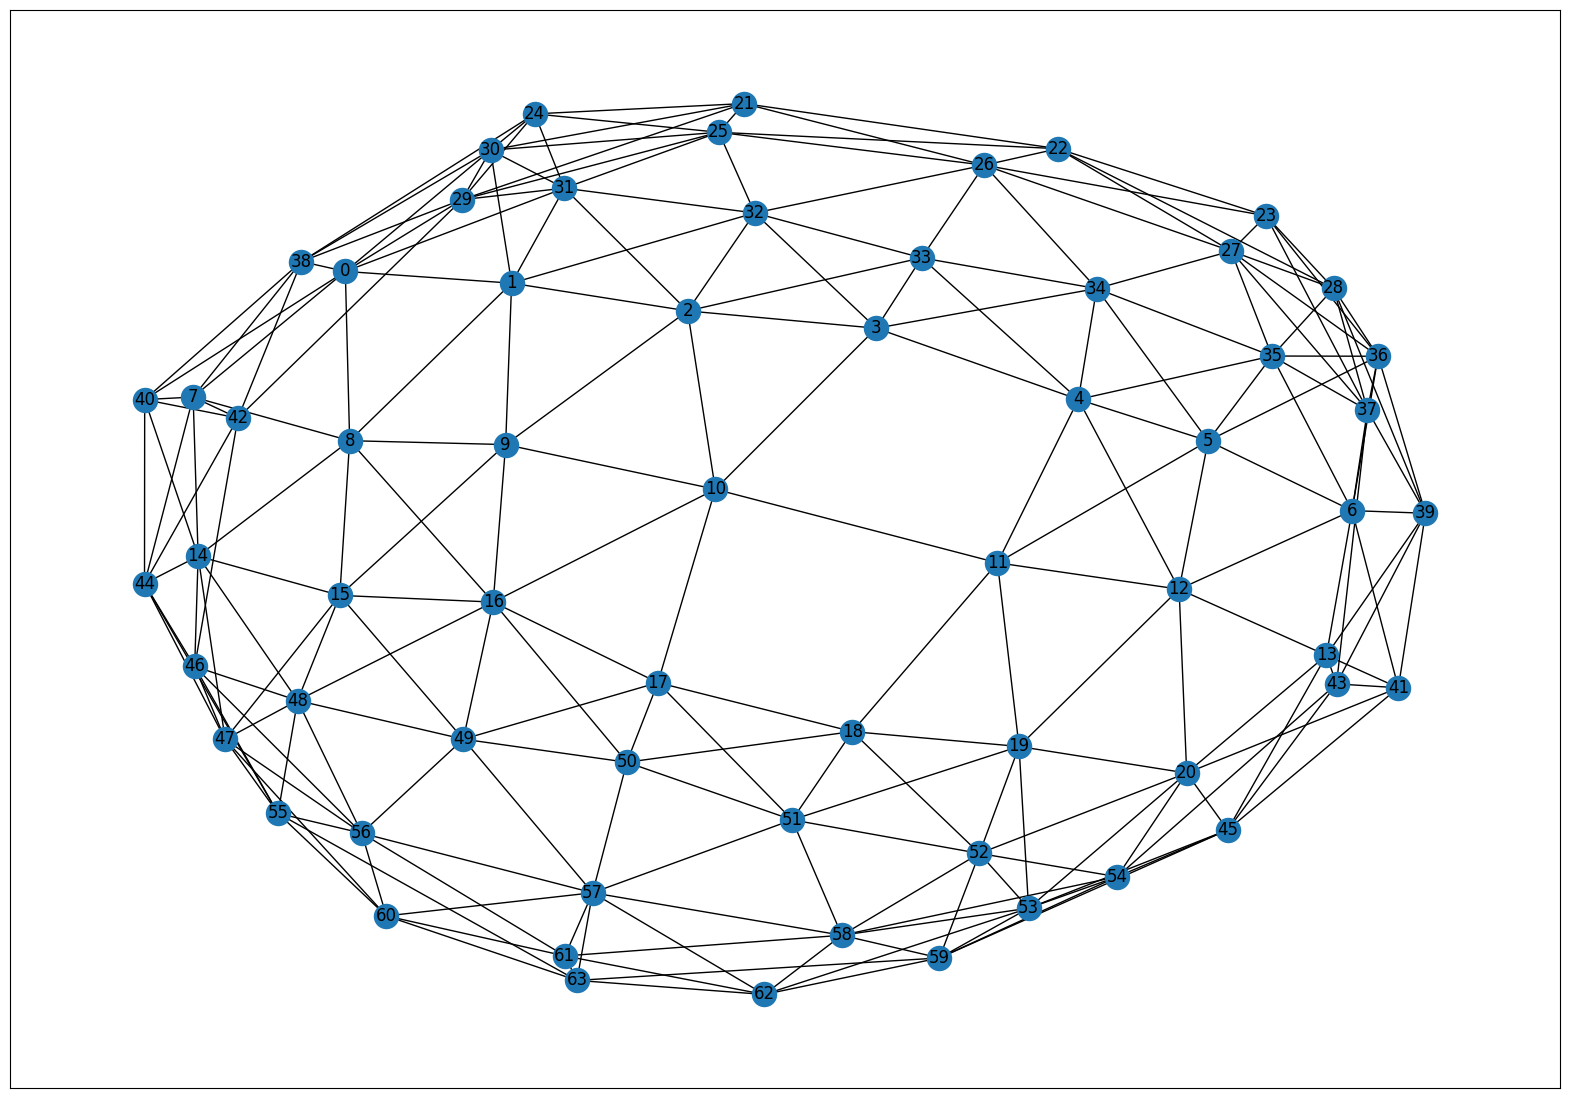

<Figure size 640x480 with 0 Axes>

In [38]:
%run structureGraph.py 

# **main.py**

In [41]:
%cd /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/

/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles


In [50]:
%%writefile main.py

# -*- coding: utf-8 -*`-
from __future__ import print_function
import os
import time
import datetime
import tqdm
import h5py
import argparse
import shutil
import random
import scipy.io

import numpy as np
from sklearn.model_selection import StratifiedKFold # k-fold cross val
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# import loadData module.
from torch_geometric.data import DataLoader, Dataset
from torch_geometric.seed import seed_everything
from utils import readConfig, load_dataset, load_model, lr_scheduler
#########
def reproducing_set(seed = 0):
    # be sure reproducing
    # os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # reproducing the result.
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    seed_everything(seed)
    #############

# command line parameters -c
parser = argparse.ArgumentParser()
parser.add_argument("-c", type = str, help = "configuration file", default = "/kaggle/working/model.config")
args = parser.parse_args()

# read config files.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfgPath, cfgPreprocess, cfgTrain, cfgModel = readConfig(args.c)

# cfgPth parameters.
data_path = cfgPath['data_path']
log_dir = cfgPath['log_dir']

# cfgTrain parameters.
kf_num = int(cfgTrain['kf_num'])
batch_size = int(cfgTrain['batch_size'])
learning_rate = float(cfgTrain['learning_rate'])
num_epochs = int(cfgTrain['num_epochs'])
seed = int(cfgTrain['seed'])
lr_scheduler_value = int(cfgTrain['lr_scheduler_value'])

# cfgModel parameters
model_name = cfgModel['model_name']
num_classes = int(cfgModel['num_classes'])

# set reproducing.
reproducing_set(seed = seed)

best_acc = torch.zeros(kf_num) # run for kf_num times
best_f1 = torch.zeros(kf_num)
best_kappa = torch.zeros(kf_num)
best_model_state_list = list([]) # save the best model state_dict and corresponding epoch.
best_acc_epoch = torch.zeros(kf_num)
best_f1_epoch = torch.zeros(kf_num)
best_kappa_epoch = torch.zeros(kf_num)
test_acc_list = list([])  # test dataset acc list.
test_f1_list = list([])
test_kappa_list = list([])
train_acc_list = list([])  # train dataset acc list.
training_loss_list = list([])
test_loss_list = list([])
net_list = list([])

### KFold cross val ###
skf = StratifiedKFold(n_splits=kf_num)
# load all datas
data_path = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles'

mat_files = [f for f in os.listdir(data_path) if f.endswith('.mat')]

for mat_file in mat_files:
    data_file = os.path.join(data_path, mat_file)
    print(f"Loading file: {data_file}")
    # Load the .mat file
    #all_data = h5py.File(data_file, 'r')
    all_data = scipy.io.loadmat(data_file)
#all_data = h5py.File(data_path)
our_datas, our_labels = np.transpose(all_data['all_data']), np.transpose(all_data['all_labels'])

# k fold validation
dateStr = datetime.datetime.now().strftime('%Y%m%d-%H-%M-%S')

######
output_path = cfgPath['save_path'] + model_name + '/'

if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create save path and copy .config to it
shutil.copyfile(args.c, output_path + dateStr + ".config")
#####

run = 0
for train_index, test_index in skf.split(our_datas, our_labels):
    print('===current run:', run)
    # save log files.
    writer = SummaryWriter(log_dir + model_name + '/' + dateStr + '/' + str(run) + '/')
    trainDataset, testDataset = load_dataset(model_name, our_datas, our_labels, train_index, test_index, cfgPath, cfgPreprocess)
    model = load_model(cfgModel, device)
    model.to(device)

    # load dataset by mini-batch.
    trainLoader = DataLoader(dataset=trainDataset, batch_size=batch_size)
    testLoader = DataLoader(dataset=testDataset, batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

    # test set.
    test_acc = torch.zeros(num_epochs)  # test acc
    test_f1 = torch.zeros(num_epochs)
    test_kappa = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)
    best_model_net = model.state_dict()  # use for save the best model state_dict
    # train set.
    train_acc = torch.zeros(num_epochs)  # train acc
    training_loss = torch.zeros(num_epochs)

    # start training.
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0

        y_true = []
        y_pred = []
        # model.train() # train mode.
        for trainData, trainLabel in tqdm.tqdm(trainLoader):
            model.zero_grad()
            optimizer.zero_grad()

            trainData = trainData.to(device)
            outputs = model(trainData)  # [batch, classes]

            # (batch_size, num_classes)
            sample_num = len(trainLabel)
            labels_ = torch.zeros(sample_num, num_classes).scatter_(1, trainLabel.view(-1, 1), 1)  # one-hot encoding, MSE used

            loss = criterion(outputs.cpu(), labels_)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # record train acc.
            _, pred = outputs.cpu().max(1)
            label = trainLabel.squeeze()
            y_true.extend(label)
            y_pred.extend(pred)

        training_loss[epoch] = running_loss
        train_acc[epoch] = accuracy_score(y_true, y_pred)
        # save log dir.
        writer.add_scalar('train_acc', train_acc[epoch], epoch)
        writer.add_scalar('train_loss', training_loss[epoch], epoch)

        # testing step.
        optimizer = lr_scheduler(optimizer, epoch, learning_rate, lr_scheduler_value)
        running_loss = 0
        y_pred = []
        y_true = []
        # model.eval()  # test mode.
        with torch.no_grad():
            for testData, testLabel in tqdm.tqdm(testLoader):

                testData = testData.to(device)
                optimizer.zero_grad()
                outputs = model(testData)

                # batch one-hot
                sample_num = len(testLabel)
                labels_ = torch.zeros(sample_num, num_classes).scatter_(1, testLabel.view(-1, 1), 1)  # one-hot encoding [batch, classes]
                loss = criterion(outputs.cpu(), labels_)
                running_loss += loss.item()

                _, predicted = outputs.cpu().max(1)
                label = testLabel.squeeze()
                y_true.extend(label)
                y_pred.extend(predicted)

            test_loss[epoch] = running_loss
            test_acc[epoch] = accuracy_score(y_true, y_pred)
            test_f1[epoch] = f1_score(y_true, y_pred, average='weighted')
            test_kappa[epoch] = cohen_kappa_score(y_true, y_pred)
            # save log dir.
            writer.add_scalar('test_acc', test_acc[epoch], epoch)
            writer.add_scalar('test_loss', test_loss[epoch], epoch)
            writer.add_scalar('test_f1', test_f1[epoch], epoch)
            writer.add_scalar('test_kappa', test_kappa[epoch], epoch)

            if best_acc[run] <= test_acc[epoch]:
                best_acc[run] = test_acc[epoch]
                best_model_net = model.state_dict()  # save the best model state.
                best_acc_epoch[run] = epoch
            if best_f1[run] <= test_f1[epoch]:
                best_f1[run] = test_f1[epoch]
                best_f1_epoch[run] = epoch
            if best_kappa[run] <= test_kappa[epoch]:
                best_kappa[run] = test_kappa[epoch]
                best_kappa_epoch = epoch

        # record train/test acc each epoch.
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        test_f1_list.append(test_f1)
        test_kappa_list.append(test_kappa)

        # print info to terminal.
        if (epoch + 1) % 1 == 0:
            print(
                'At epoch: %s, training_loss: %f, test_loss: %f, train_acc: %.3f, test_acc: %.3f, best accuracy: %.3f, time elasped: %.3f' % (
                    epoch + 1, training_loss[epoch], test_loss[epoch], train_acc[epoch], test_acc[epoch], best_acc[run],
                    time.time() - start_time))
            print('f1_score: %.3f, best_f1: %.3f, kappa_score: %.3f, best_kappa: %.3f' % (test_f1[epoch], best_f1[run], test_kappa[epoch], best_kappa[run]))
            start_time = time.time()

    run = run + 1
    ####
    training_loss_list.append(training_loss)
    test_loss_list.append(test_loss)
    ####
    net_list.append(model.state_dict())
    best_model_state_list.append(best_model_net)

# overall state
state = {
    'net_list': net_list,
    'best_acc': best_acc,
    'best_f1' : best_f1,
    'best_kappa' : best_kappa,
    'best_model_state_list': best_model_state_list,
    'best_acc_epoch': best_acc_epoch,
    'best_f1_epoch' : best_f1_epoch,
    'best_kappa_epoch' : best_kappa_epoch,
    'num_epochs': num_epochs,
    'train_acc_list': train_acc_list,
    'test_acc_list': test_acc_list,
    'test_f1_list' : test_f1_list,
    'test_kappa_list' : test_kappa_list,
    'training_loss_list': training_loss_list,
    'test_loss_list': test_loss_list,
}

# output_path = cfgPath['save_path'] + model_name + '/'
#
# if not os.path.exists(output_path):
#     os.makedirs(output_path)
#
# # Create save path and copy .config to it
# shutil.copyfile(args.c, output_path + dateStr + ".config")
torch.save(state, output_path + dateStr + '.t7')

print('Avg acc: %f, std: %f, Avg f1: %f, std: %f, Avg kappa: %f, std: %f' % (torch.mean(state['best_acc']), torch.std(state['best_acc']), torch.mean(state['best_f1']), torch.std(state['best_f1']), torch.mean(state['best_kappa']), torch.std(state['best_kappa'])))



Overwriting main.py


In [51]:
%run main.py 

Config: /kaggle/working/model.config
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R13.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R02.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R05.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R12.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R10.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R11.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R03.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R07.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R09.mat
Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R04.mat
Loading file: /kaggle/working/physionet.org/files/eeg

KeyError: 'all_data'

In [52]:
import scipy.io

# Load the .mat file
print(f"Loading file: {data_file}")
all_data = scipy.io.loadmat(data_file)

# Print the keys to check what variables are present
print(f"Keys in the .mat file: {all_data.keys()}")

# If you're unsure what data is present, you can inspect it like this:
for key in all_data:
    print(f"{key}: {type(all_data[key])}, shape: {all_data[key].shape if hasattr(all_data[key], 'shape') else 'N/A'}")


Loading file: /kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles/S002R14.mat
Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'eeg_data', 'sampling_rate'])
__header__: <class 'bytes'>, shape: N/A
__version__: <class 'str'>, shape: N/A
__globals__: <class 'list'>, shape: N/A
eeg_data: <class 'numpy.ndarray'>, shape: (64, 19680)
sampling_rate: <class 'numpy.ndarray'>, shape: (1, 1)


In [39]:
%cd /kaggle/working/MI_electrode_positions.txt

[Errno 20] Not a directory: '/kaggle/working/MI_electrode_positions.txt'
/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles


In [57]:
%%writefile main.py

# -*- coding: utf-8 -*-
from __future__ import print_function
import os
import time
import datetime
import tqdm
import h5py
import argparse
import shutil
import random
import scipy.io

import numpy as np
from sklearn.model_selection import StratifiedKFold # k-fold cross val
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# import loadData module.
from torch_geometric.data import DataLoader, Dataset
from torch_geometric.seed import seed_everything
from utils1 import readConfig, load_dataset, load_model, lr_scheduler
from structureGraph import BrainGraphMB
#from brain_graph import BrainGraphMB

#########
def reproducing_set(seed = 0):
    # ensure reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # ensure deterministic behavior
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    seed_everything(seed)
#############

# command line parameters -c
parser = argparse.ArgumentParser()
parser.add_argument("-c", type = str, help = "configuration file", default = "/kaggle/working/model.config")
args = parser.parse_args()

# read config files.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfgPath, cfgPreprocess, cfgTrain, cfgModel = readConfig(args.c)

# cfgPth parameters.
data_path = cfgPath['data_path']
log_dir = cfgPath['log_dir']

# cfgTrain parameters.
kf_num = int(cfgTrain['kf_num'])
batch_size = int(cfgTrain['batch_size'])
learning_rate = float(cfgTrain['learning_rate'])
num_epochs = int(cfgTrain['num_epochs'])
seed = int(cfgTrain['seed'])
lr_scheduler_value = int(cfgTrain['lr_scheduler_value'])

# cfgModel parameters
model_name = cfgModel['model_name']
num_classes = int(cfgModel['num_classes'])

# set reproducibility.
reproducing_set(seed = seed)

best_acc = torch.zeros(kf_num)  # run for kf_num times
best_f1 = torch.zeros(kf_num)
best_kappa = torch.zeros(kf_num)
best_model_state_list = list([])  # save the best model state_dict and corresponding epoch.
best_acc_epoch = torch.zeros(kf_num)
best_f1_epoch = torch.zeros(kf_num)
best_kappa_epoch = torch.zeros(kf_num)
test_acc_list = list([])  # test dataset accuracy list.
test_f1_list = list([])
test_kappa_list = list([])
train_acc_list = list([])  # training dataset accuracy list.
training_loss_list = list([])
test_loss_list = list([])
net_list = list([])

### KFold cross validation ###
skf = StratifiedKFold(n_splits=kf_num)
# load all data
data_path = '/kaggle/working/physionet.org/files/eegmmidb/1.0.0/S002/matfiles'

#mat_files = [f for f in os.listdir(data_path) if f.endswith('.mat')]
file_paths= [f for f in os.listdir(data_path) if f.endswith('.mat')]
# Initialize lists for data and labels
all_eeg_data = []
all_labels = []

# Load each .mat file and extract EEG data and corresponding labels
for file_path in file_paths:  # Assuming file_paths is a list of your .mat file paths
    mat_data = scipy.io.loadmat(file_path)  # Load the .mat file
    eeg_data = mat_data['eeg_data'][0]  # Adjust the key according to your .mat structure
    sampling_rate = mat_data['sampling_rate'][0]  # Adjust the key according to your .mat structure

    all_eeg_data.append(eeg_data)

    # Assuming you have a way to determine labels for each file
    # For example, you might define labels based on file name or another criterion
    label = 0 if 'R04' in file_path else 1  # Example condition for labels
    num_samples = eeg_data.shape[0]
    all_labels.extend([label] * num_samples)  # Extend the labels list with the appropriate label

# Now concatenate all EEG data to form a single dataset for KFold
our_datas = np.concatenate(all_eeg_data, axis=0)
our_labels = np.array(all_labels)  # Convert the list of labels to a NumPy array

# k fold validation
dateStr = datetime.datetime.now().strftime('%Y%m%d-%H-%M-%S')

###### Output path setup ######
output_path = cfgPath['save_path'] + model_name + '/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create save path and copy .config to it
shutil.copyfile(args.c, output_path + dateStr + ".config")
###############################

run = 0
for train_index, test_index in skf.split(our_datas, our_labels):
    print('===current run:', run)
    
    # Save log files
    writer = SummaryWriter(log_dir + model_name + '/' + dateStr + '/' + str(run) + '/')
    trainDataset, testDataset = load_dataset(model_name, our_datas, our_labels, train_index, test_index, cfgPath, cfgPreprocess)
    model = load_model(cfgModel, device)
    model.to(device)

    # Load dataset by mini-batch
    trainLoader = DataLoader(dataset=trainDataset, batch_size=batch_size)
    testLoader = DataLoader(dataset=testDataset, batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

    # Metrics for testing
    test_acc = torch.zeros(num_epochs)
    test_f1 = torch.zeros(num_epochs)
    test_kappa = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)
    best_model_net = model.state_dict()  # Save the best model state

    # Metrics for training
    train_acc = torch.zeros(num_epochs)
    training_loss = torch.zeros(num_epochs)

    # Start training
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0

        y_true = []
        y_pred = []

        # Training loop
        for trainData, trainLabel in tqdm.tqdm(trainLoader):
            model.zero_grad()
            optimizer.zero_grad()

            trainData = trainData.to(device)
            outputs = model(trainData)  # [batch, classes]

            sample_num = len(trainLabel)
            labels_ = torch.zeros(sample_num, num_classes).scatter_(1, trainLabel.view(-1, 1), 1)  # One-hot encoding

            loss = criterion(outputs.cpu(), labels_)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Record train accuracy
            _, pred = outputs.cpu().max(1)
            label = trainLabel.squeeze()
            y_true.extend(label)
            y_pred.extend(pred)

        training_loss[epoch] = running_loss
        train_acc[epoch] = accuracy_score(y_true, y_pred)
        
        # Save logs
        writer.add_scalar('train_acc', train_acc[epoch], epoch)
        writer.add_scalar('train_loss', training_loss[epoch], epoch)

        # Testing step
        optimizer = lr_scheduler(optimizer, epoch, learning_rate, lr_scheduler_value)
        running_loss = 0
        y_pred = []
        y_true = []

        with torch.no_grad():
            for testData, testLabel in tqdm.tqdm(testLoader):
                testData = testData.to(device)
                optimizer.zero_grad()
                outputs = model(testData)

                sample_num = len(testLabel)
                labels_ = torch.zeros(sample_num, num_classes).scatter_(1, testLabel.view(-1, 1), 1)
                loss = criterion(outputs.cpu(), labels_)
                running_loss += loss.item()

                _, predicted = outputs.cpu().max(1)
                label = testLabel.squeeze()
                y_true.extend(label)
                y_pred.extend(predicted)

            test_loss[epoch] = running_loss
            test_acc[epoch] = accuracy_score(y_true, y_pred)
            test_f1[epoch] = f1_score(y_true, y_pred, average='weighted')
            test_kappa[epoch] = cohen_kappa_score(y_true, y_pred)
            
            # Save logs
            writer.add_scalar('test_acc', test_acc[epoch], epoch)
            writer.add_scalar('test_loss', test_loss[epoch], epoch)
            writer.add_scalar('test_f1', test_f1[epoch], epoch)
            writer.add_scalar('test_kappa', test_kappa[epoch], epoch)

            # Save best model based on accuracy
            if best_acc[run] <= test_acc[epoch]:
                best_acc[run] = test_acc[epoch]
                best_model_net = model.state_dict()
                best_acc_epoch[run] = epoch

            # Save best F1 score
            if best_f1[run] <= test_f1[epoch]:
                best_f1[run] = test_f1[epoch]
                best_f1_epoch[run] = epoch

            # Save best kappa score
            if best_kappa[run] <= test_kappa[epoch]:
                best_kappa[run] = test_kappa[epoch]
                best_kappa_epoch = epoch

        # Record metrics
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        test_f1_list.append(test_f1)
        test_kappa_list.append(test_kappa)

        print('training epoch time elapsed: ', time.time() - start_time, 's')

    best_model_state_list.append(best_model_net)
    run += 1

    # Save models to path
    torch.save(best_model_state_list, output_path + model_name + '_finalNet.pt')
    
print("End training")


Overwriting main.py


In [58]:
%run main.py


Config: /kaggle/working/model.config
===current run: 0


FileNotFoundError: '/kaggle/working/MI_electrode_positions.txt' not found.